## Configuração Inicial do Ambiente
Este trecho de código é responsável por configurar o ambiente necessário para automação web utilizando o Selenium. Ele inclui a instalação do Google Chrome e do ChromeDriver, essencial para rodar testes em um navegador em modo headless (sem interface gráfica).
Também são instaladas e importadas todas as bibliotecas necessárias.
Além disso, configura-se o WebDriver para capturar logs detalhados de desempenho.

In [1]:
# Instalar o Google Chrome
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt install ./google-chrome-stable_current_amd64.deb
!apt-get install -yqq unzip

# Ver a versão do Chrome instalada
!google-chrome --version

# Instalar ChromeDriverManager
!pip install selenium
!pip install webdriver-manager

# Importação das bibliotecas necessárias
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuração do WebDriver para rodar em modo headless
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--window-size=1920x1080')
options.add_experimental_option('perfLoggingPrefs', {'enableNetwork': True})
options.add_argument('--enable-logging')
options.add_argument('--v=1')
options.set_capability("goog:loggingPrefs", {"performance": "ALL", "browser": "ALL"})

# Inicialização do WebDriver com o ChromeDriverManager
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)


--2024-06-12 02:57:26--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 142.251.167.136, 142.251.167.190, 142.251.167.93, ...
Connecting to dl.google.com (dl.google.com)|142.251.167.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108755056 (104M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 103.72M   234MB/s    in 0.4s    

2024-06-12 02:57:27 (234 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [108755056/108755056]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'google-chrome-stable' instead of './google-chrome-stable_current_amd64.deb'
The following additional packages will be installed:
  libu2f-udev libudev1 libvulkan1 mesa-vulkan-drivers systemd-hwe-hwdb udev
The following NEW packages will be installed:
  google-chrome-stab

#Coleta de Dados

## Funções de Interação e Extração de Dados
Série de funções destinadas a interagir com elementos web e extrair dados de forma eficiente. As funções incluem métodos para rolar a página e localizar textos específicos, clicar em elementos interativos, e extrair dados baseados nos logs de desempenho do navegador. Há também funções específicas para encontrar e interagir com botões de paginação, permitindo a navegação através de múltiplas páginas de dados.

---


Realizamos desta forma pois os caminhos para as APIs de interesse só são chamados quando as interações com a página acontecem. Por exemplo, a tabela de interesse no sofascore possui 29 páginas, e para acessar cada requisição precisamos clicar no botão 'próximo', uma seta.
 Já que no colab não conseguimos ver a interação na prática, colocamos alguns prints que atualizam sobre o andamento da extração.


In [2]:
# Função para rolar a página e encontrar um texto específico
def scroll_and_find_text(driver, text):
    scroll_increment = 300
    last_height = driver.execute_script("return document.body.scrollHeight")
    current_position = 0
    while True:
        print(f"Procurando por texto: {text}")
        try:
            elements = driver.find_elements(By.XPATH, f"//*[contains(text(), '{text}')]")
            for element in elements:
                if element.is_displayed():
                    print(f"Texto '{text}' encontrado!")
                    return element
        except Exception as e:
            print(f"Erro ao procurar pelo texto: {e}")
        current_position += scroll_increment
        driver.execute_script("window.scrollTo(0, {current_position});")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if current_position >= new_height:
            print("Chegou ao final da página e não encontrou o texto.")
            break
        last_height = new_height
    return None

# Função para clicar em um elemento da página
def click_element(element, use_js=False):
    try:
        actions = ActionChains(driver)
        actions.move_to_element(element).perform()
        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", element)
        if use_js:
            # Clique usando JavaScript se necessário
            driver.execute_script("arguments[0].click();", element)
        else:
            WebDriverWait(driver, 10).until(EC.element_to_be_clickable(element)).click()
        return True
    except Exception as e:
        print(f"Erro ao tentar clicar no elemento: {e}")
        return False

# Função para extrair dados dos logs de desempenho do navegador
def extract_data_from_logs(driver, api_path):
    logs_raw = driver.get_log("performance")
    logs = [json.loads(lr["message"])["message"] for lr in logs_raw]
    for x in logs:
        if 'params' in x and 'request' in x['params'] and 'url' in x['params']['request']:
            request_url = x['params']['request']['url']
            if api_path in request_url:
                print(f"Requisição encontrada: {request_url}")
                request_id = x['params']['requestId']
                response_body = json.loads(driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': request_id})['body'])
                return response_body['results']
    return []

# Função para encontrar e clicar no botão 'próximo'
def scroll_and_find_next_button(driver):
    scroll_increment = 300
    current_position = driver.execute_script("return window.pageYOffset;")
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        print("Procurando pelo botão 'próximo'")
        try:
            next_button = driver.find_element(By.XPATH, "//button[@class='Button llwjsV' and @style='justify-content: flex-end;']")
            if next_button.is_displayed():
                print("Botão 'próximo' encontrado!")
                return next_button
        except Exception as e:
            print(f"Erro ao procurar pelo botão 'próximo': {e}")
        current_position += scroll_increment
        driver.execute_script("window.scrollTo(0, {current_position});")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if current_position >= new_height:
            print("Chegou ao final da página e não encontrou o botão 'próximo'.")
            break
        last_height = new_height
    return None

# Função para clicar no botão 'próximo' encontrado
def click_next_button(driver):
    try:
        next_button = scroll_and_find_next_button(driver)
        if next_button:
            actions = ActionChains(driver)
            actions.move_to_element(next_button).perform()
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", next_button)
            WebDriverWait(driver, 10).until(EC.element_to_be_clickable(next_button)).click()  # Espera até que o botão seja clicável e clica
            return True
        else:
            print("Botão 'próximo' não encontrado.")
            return False
    except Exception as e:
        print(f"Erro ao tentar clicar no próximo botão: {e}")
        return False

# Execução do script
try:
    driver.get("https://www.sofascore.com/pt/torneio/futebol/england/premier-league/17#id:52186")
    print("Página carregada com sucesso!")

    first_element = scroll_and_find_text(driver, 'Jogadores com menos jogos')
    if first_element:
        if click_element(first_element):
            print("Primeiro botão clicado.")
        else:
            print("Falha ao clicar no primeiro botão.")
        time.sleep(2)
    else:
        print("Primeiro texto 'Jogadores com menos jogos' não encontrado.")

    second_element = scroll_and_find_text(driver, 'Todos os jogadores')
    if second_element:
        if click_element(second_element, use_js=True):  # Utiliza JavaScript para clicar no segundo botão
            print("Segundo botão clicado")
        else:
            print("Falha ao clicar no segundo botão.")
        time.sleep(2)
    else:
        print("Segundo texto 'Todos os jogadores' não encontrado.")

    all_players_data = []

    api_path_first_page = '/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&accumulation=total&group=summary'
    print("Extraindo dados da primeira página")
    players_data = extract_data_from_logs(driver, api_path_first_page)
    if players_data:
        all_players_data.extend(players_data)
        print(f"{len(players_data)} jogadores extraídos na primeira página.")
    else:
        print("Nenhum jogador extraído na primeira página.")

    for page in range(1, 29):
        if not click_next_button(driver):
            break
        time.sleep(2)
        offset = page * 20
        api_path = f'/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&offset={offset}&accumulation=total&group=summary'
        print(f"Extraindo dados da página {page + 1} com offset {offset}")
        players_data = extract_data_from_logs(driver, api_path)
        if players_data:
            all_players_data.extend(players_data)
            print(f"{len(players_data)} jogadores extraídos.")
        else:
            print("Nenhum jogador extraído nesta página.")

    relevant_data = []
    for player in all_players_data:
        relevant_data.append({
            'goals': player.get('goals'),
            'expectedGoals': player.get('expectedGoals'),
            'successfulDribbles': player.get('successfulDribbles'),
            'tackles': player.get('tackles'),
            'assists': player.get('assists'),
            'accuratePassesPercentage': player.get('accuratePassesPercentage'),
            'rating': player.get('rating'),
            'player_name': player['player']['name'],
            'team_name': player['team']['name']
        })

    df = pd.DataFrame(relevant_data)
    df.to_csv('players_data.csv', index=False)
    print("DataFrame salvo em 'players_data.csv'")
except Exception as e:
    print("Erro durante a navegação:", e)
finally:
    driver.quit()
    print("Driver fechado.")

Página carregada com sucesso!
Procurando por texto: Jogadores com menos jogos
Texto 'Jogadores com menos jogos' encontrado!
Primeiro botão clicado.
Procurando por texto: Todos os jogadores
Texto 'Todos os jogadores' encontrado!
Segundo botão clicado
Extraindo dados da primeira página
Requisição encontrada: https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&accumulation=total&group=summary
20 jogadores extraídos na primeira página.
Procurando pelo botão 'próximo'
Botão 'próximo' encontrado!
Extraindo dados da página 2 com offset 20
Requisição encontrada: https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&offset=20&accumulation=total&group=summary
20 jogadores extraídos.
Procurando pelo botão 'próximo'
Botão 'próximo' encontrado!
Extraindo dados da página 3 com offset 40
Requisição encontrada: https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rat

#Pré-processamento dos dados

##Análise exploratória inicial do DataFrame




In [3]:
# Exibe os tipos de dados das colunas
print(df.dtypes)

# Exibe as primeiras linhas do DataFrame
print(df.head())

# Exibe a descrição do DataFrame
print(df.describe())

# Dimensões do data frame
print(df.shape)

goals                         int64
expectedGoals               float64
successfulDribbles            int64
tackles                       int64
assists                       int64
accuratePassesPercentage    float64
rating                      float64
player_name                  object
team_name                    object
dtype: object
   goals  expectedGoals  successfulDribbles  tackles  assists  \
0      8           4.07                  42       70        9   
1      0            NaN                   0        1        0   
2      4           2.41                  10       14       10   
3     19          10.34                  47       31        8   
4     10          10.01                  19       68        8   

   accuratePassesPercentage  rating      player_name          team_name  
0                     92.46    8.01            Rodri    Manchester City  
1                     67.49    8.00   Arijanet Murić            Burnley  
2                     83.83    7.93  Kevin De Bru

##Definição de Tipos




In [4]:
# Transformando 'player_name' e 'team_name' em categorias
df['player_name'] = df['player_name'].astype('category')
df['team_name'] = df['team_name'].astype('category')

##Limpeza de dados inicial

Análise de quantos valores ausentes existem por coluna

In [5]:
# Exibe os valores ausentes por coluna antes da limpeza
print("Valores ausentes por coluna antes da limpeza:")
print(df.isnull().sum())

Valores ausentes por coluna antes da limpeza:
goals                        0
expectedGoals               48
successfulDribbles           0
tackles                      0
assists                      0
accuratePassesPercentage     0
rating                       0
player_name                  0
team_name                    0
dtype: int64


Decidimos remover todos os jogadores que possuem ratings iguais a zero, pois isso significa que eles jogaram poucos minutos no campeonato. Como não temos uma coluna de quantidade de jogos, pensamos nessa forma para retirar jogadores que não nos trariam análises fiéis

In [6]:
# Primeira remoção: jogadores com rating igual a zero
initial_count = len(df)
removed_rating_zero = df[df['rating'] == 0]
df = df[df['rating'] != 0]
after_rating_removal_count = len(df)
rating_removal_info = {
    'names': removed_rating_zero['player_name'].tolist(),
    'count': initial_count - after_rating_removal_count
}

Outro método que encontramos de remover jogadores que pouco jogaram no campeonato foi pela coluna 'expectedGoals'. Essa coluna diz respeito aos gols esperados do jogador durante todo o campeonato, cada chute dele tem uma chance de ser gol. Se o valor dessa coluna for zero, quer dizer que ele não deu um chute na competição inteira. Além disso, também estaremos provavelmente removendo os goleiros com essa limpeza, pois eles muito raramente dão chutes. Decidimos por essa remoção pois as colunas da nossa base de dados não possuem dados voltados para estatísticas de goleiros, não encontramos nenhuma análise interessante a ser feita

O que é o campo excepctedGoals(xG) e como ele é calculado?  

*   É a probabilidade de uma finalização resultar em gol.
*   Existem diferentes maneiras de calcular o xG.
*   Os modelos tradicionais básicos adotam critérios como: distância, ângulo, cabeçada ou chute, perna dominante, situação de jogo, pressionado ou livre, entre outros.
*   A partir disso, cada modelo processa de formas diferentes essas informações, mas o objetivo final é o mesmo, chegar a um número decimal entre 0,0 e 1,0.
* Então, por exemplo, um xG=0,5 significa que a chance daquela finalização resultar em gol é de 50%.

No nosso modelo de dados, a coluna é referente ao acumulado de xG que um jogador tem durante todo o campeonato



In [7]:
# Segunda remoção: jogadores com expectedGoals nulo ou zero
removed_expected_goals_na_or_zero = df[df['expectedGoals'].isna() | (df['expectedGoals'] == 0)]
df = df[df['expectedGoals'].notna() & (df['expectedGoals'] != 0)]
after_expected_goals_removal_count = len(df)
expected_goals_removal_info = {
    'names': removed_expected_goals_na_or_zero['player_name'].tolist(),
    'count': after_rating_removal_count - after_expected_goals_removal_count
}




*   Como os dados estão após a limpeza
*   Quais jogadores foram removidos após a limpeza -> Como temos conhecimento a respeito do domínio, é possível identificar se algum jogador foi removido incorretamente



In [8]:
# Exibe as primeiras linhas do DataFrame após a limpeza
print("DataFrame após a limpeza:")
print(df.head())
print(df.describe())

# Exibe informações sobre as remoções
print("Jogadores removidos devido ao rating zero:")
print(f"Quantidade: {rating_removal_info['count']}")
print(f"Nomes: {rating_removal_info['names']}")

print("Jogadores removidos devido ao expectedGoals nulo ou zero:")
print(f"Quantidade: {expected_goals_removal_info['count']}")
print(f"Nomes: {expected_goals_removal_info['names']}")

DataFrame após a limpeza:
   goals  expectedGoals  successfulDribbles  tackles  assists  \
0      8           4.07                  42       70        9   
2      4           2.41                  10       14       10   
3     19          10.34                  47       31        8   
4     10          10.01                  19       68        8   
5     10           5.51                  40       19        6   

   accuratePassesPercentage  rating      player_name          team_name  
0                     92.46    8.01            Rodri    Manchester City  
2                     83.83    7.93  Kevin De Bruyne    Manchester City  
3                     89.10    7.79       Phil Foden    Manchester City  
4                     79.38    7.75  Bruno Fernandes  Manchester United  
5                     83.09    7.74    Michael Olise     Crystal Palace  
            goals  expectedGoals  successfulDribbles     tackles     assists  \
count  459.000000     459.000000          459.000000  459.0

Conseguimos confirmar que os jogadores removidos pelo expectedGoals igual a zero são goleiros ou jogadores que atuaram muito pouco, a ponto de não realizarem nenhum chute no campeonato.

Reinicialização do índice do DataFrame

In [9]:
df.reset_index(inplace=True,drop = True)

Remoção de Registros Duplicados

In [10]:
print(f"Quantidade de registros antes da remoção de duplicatas: {len(df)}")

# Exibir registros duplicados, se houver
print(df[df.duplicated()])

# Remover registros duplicados, mantendo a primeira ocorrência
df.drop_duplicates(keep='first', inplace=True)

# Exibir a nova contagem de registros para verificar
print(f"Quantidade de registros após remoção de duplicatas: {len(df)}")


Quantidade de registros antes da remoção de duplicatas: 459
Empty DataFrame
Columns: [goals, expectedGoals, successfulDribbles, tackles, assists, accuratePassesPercentage, rating, player_name, team_name]
Index: []
Quantidade de registros após remoção de duplicatas: 459


##Removendo Outliers Utilizando Z-score Robusto (Univariado)

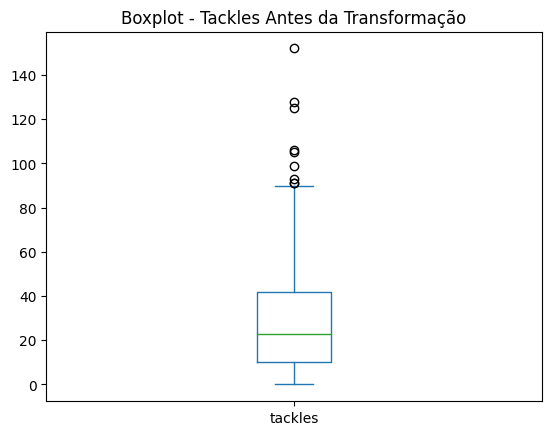

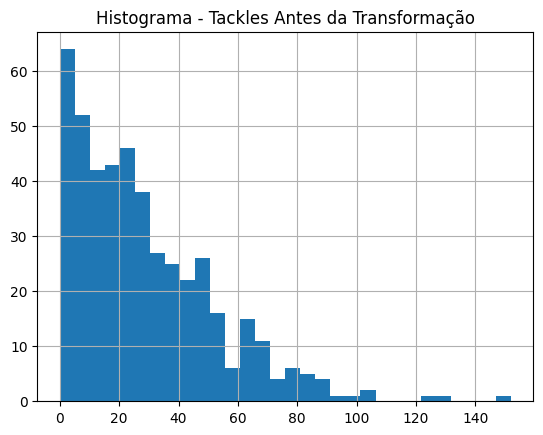

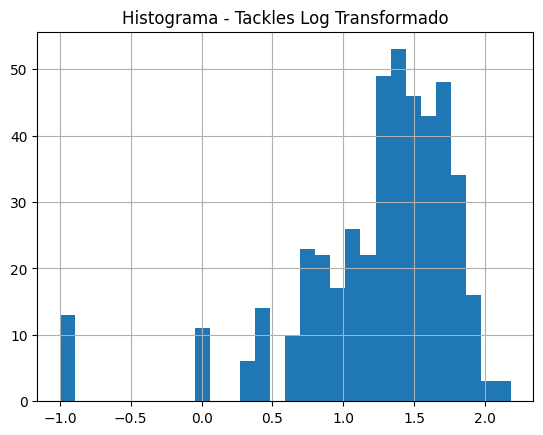

Jogadores identificados como outliers em tackles:
['Aleksandar Mitrović', 'Davinson Sánchez', 'Aymeric Laporte', 'Nick Pope', 'Mohamed Elneny', 'Philippe Coutinho', 'George Earthy', 'Michael Obafemi', 'Kieffer Moore', 'Tyrone Mings', 'Benicio Boaitey', 'Divin Mubama', 'Andrey Santos']
Deseja remover os outliers identificados? (sim/não): sim
Outliers removidos.


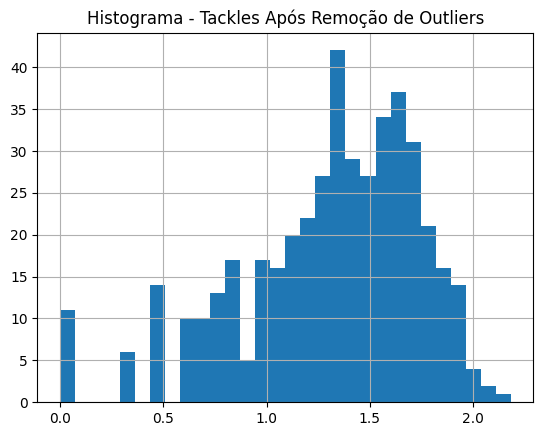

Quantidade de registros após decisão sobre outliers em tackles: 446


In [11]:
import matplotlib.pyplot as plt
from numpy import abs, log10
import pandas as pd

# Visualização inicial da distribuição de 'tackles'
df['tackles'].plot.box()
plt.title("Boxplot - Tackles Antes da Transformação")
plt.show()

df['tackles'].hist(bins=30)
plt.title("Histograma - Tackles Antes da Transformação")
plt.show()

# Convertendo para log para normalizar a distribuição, se necessário
df['tackles_log'] = log10(df['tackles'].replace(0, 0.1))  # Ajustando para evitar log de zero

# Visualizando a distribuição transformada
df['tackles_log'].hist(bins=30)
plt.title("Histograma - Tackles Log Transformado")
plt.show()

# Calculando o MAD (Desvio Médio Absoluto)
mad = abs(df['tackles_log'] - df['tackles_log'].median()).median() * (1 / 0.6745)

# Identificando e capturando os nomes dos jogadores outliers
outliers = df[abs(df['tackles_log'] - df['tackles_log'].median()) / mad >= 3.5]
outlier_names = outliers['player_name'].tolist()

if outlier_names:
    print("Jogadores identificados como outliers em tackles:")
    print(outlier_names)
    # Perguntar ao usuário se deseja remover os outliers
    remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")
    if remove_outliers.lower() == 'sim':
        df = df[abs(df['tackles_log'] - df['tackles_log'].median()) / mad < 3.5]
        print("Outliers removidos.")
        df['tackles_log'].hist(bins=30)
        plt.title("Histograma - Tackles Após Remoção de Outliers")
        plt.show()
    else:
        print("Nenhuma ação foi tomada.")
else:
    print("Nenhum outlier identificado em tackles.")

print(f"Quantidade de registros após decisão sobre outliers em tackles: {len(df)}")







Decidimos remover os outilers pois esse método foi uma ótima forma de identificar jogadores que pouco jogaram e não nos fornecerão dados relevantes. Os outlier de desarmes se encaixam bem nesse contexto.

#Remoção de Outliers (univariado, bivariado e multivariado)

##Removendo Outliers Utilizando Método de Tukey (Univariado)

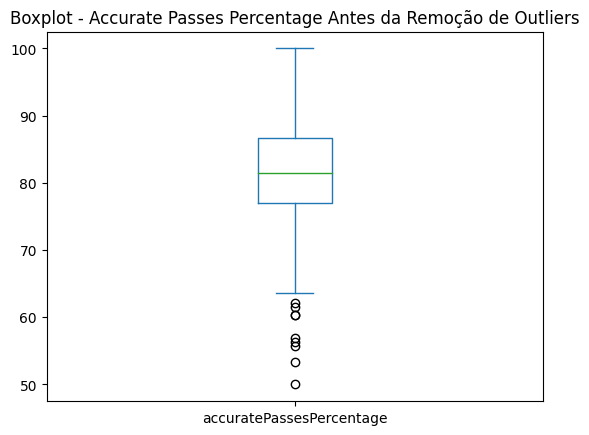

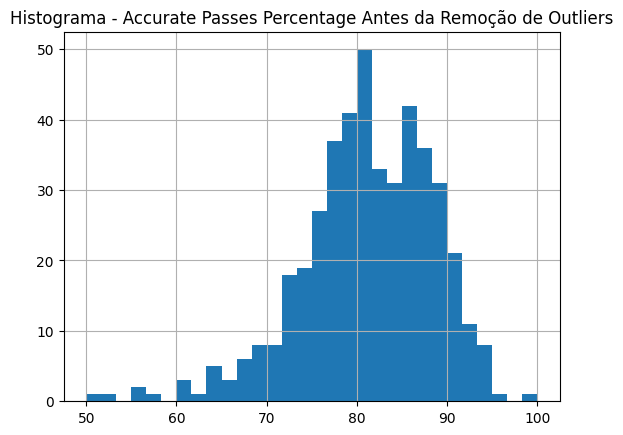

Jogadores identificados como outliers em Accurate Passes Percentage:
['Rodrigo Muniz', 'Ivan Toney', 'Oliver McBurnie', 'Dominic Calvert-Lewin', 'Jacob Brown', 'Beto', 'Youssef Chermiti', 'Alejo Véliz', 'William Osula']
Deseja remover os outliers identificados? (sim/não): não
Nenhuma ação tomada ou nenhum outlier para remover.
Quantidade de registros após decisão sobre outliers em Accurate Passes Percentage: 446


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualização inicial da distribuição de 'accuratePassesPercentage'
df['accuratePassesPercentage'].plot.box()
plt.title("Boxplot - Accurate Passes Percentage Antes da Remoção de Outliers")
plt.show()

df['accuratePassesPercentage'].hist(bins=30)
plt.title("Histograma - Accurate Passes Percentage Antes da Remoção de Outliers")
plt.show()

# Calculando o IQR
Q1 = df['accuratePassesPercentage'].quantile(0.25)
Q3 = df['accuratePassesPercentage'].quantile(0.75)
IQR = Q3 - Q1

# Identificando outliers
outliers = df[(df['accuratePassesPercentage'] < (Q1 - 1.5 * IQR)) | (df['accuratePassesPercentage'] > (Q3 + 1.5 * IQR))]
outlier_names = outliers['player_name'].tolist()

if outlier_names:
    print("Jogadores identificados como outliers em Accurate Passes Percentage:")
    print(outlier_names)
else:
    print("Nenhum outlier identificado em Accurate Passes Percentage.")

# Perguntar ao usuário se deseja remover os outliers
remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")

if remove_outliers.lower() == 'sim' and outlier_names:
    df = df[(df['accuratePassesPercentage'] >= (Q1 - 1.5 * IQR)) & (df['accuratePassesPercentage'] <= (Q3 + 1.5 * IQR))]
    print("Outliers removidos.")
    df['accuratePassesPercentage'].hist(bins=30)
    plt.title("Histograma - Accurate Passes Percentage Após Remoção de Outliers")
    plt.show()
else:
    print("Nenhuma ação tomada ou nenhum outlier para remover.")

print(f"Quantidade de registros após decisão sobre outliers em Accurate Passes Percentage: {len(df)}")




Decidimos não remover os outilers, pois, apesar deles terem sido identificados, não são dados "errados" por apenas estarem com um valor baixo para porcentagem de passes. Por exemplo, identificamos um certo padrão: quatro jogadores dessa lista, Rodrigo Muniz, Ivan Toney, Dominic Calvert-Lewin e Beto são centroavantes, jogam muito próximos ao gol. Por isso, acabam passando a bola menos que os demais jogadores, e os passes deles tendem a ser mais arriscados, uma possível explicação do por que essa porcentagem é baixa.

##Removendo Outliers Usando Razão de Duas Variáveis (Bivariado)

Tamanho do DataFrame antes da identificação de outliers: 446


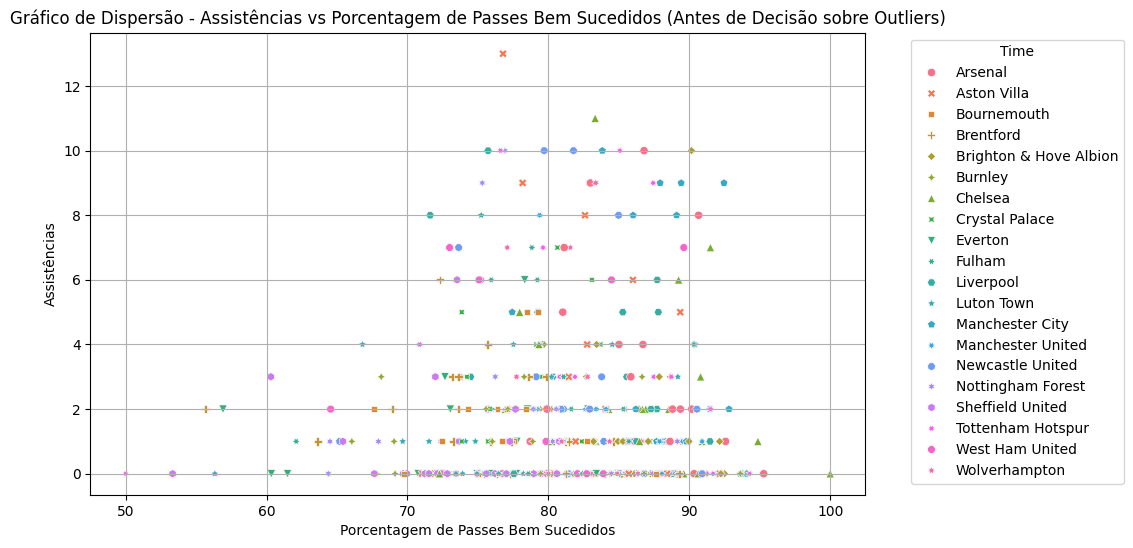

Nenhum outlier identificado.
Quantidade final de registros: 446


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log10, abs
import seaborn as sns
import pandas as pd

# Preparando a relação entre Assistências e Porcentagem de Passes Bem Sucedidos
df['assists_passes_ratio'] = df['assists'] / df['accuratePassesPercentage']
df['assists_passes_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Aplicando logaritmo e tratando valores zero
df['assists_passes_ratio_log'] = log10(df['assists_passes_ratio'].replace(0, np.nan))

# Calculando o MAD para identificar outliers
mad_ratio = abs(df['assists_passes_ratio_log'] - df['assists_passes_ratio_log'].median()).median() * (1 / 0.6745)
outlier_mask = abs(df['assists_passes_ratio_log'] - df['assists_passes_ratio_log'].median()) / mad_ratio >= 3.5

# Identificando e salvando os nomes dos jogadores removidos como outliers
outliers = df[outlier_mask]
outlier_names = outliers['player_name'].tolist()

# Imprimindo o tamanho do DataFrame no início
print("Tamanho do DataFrame antes da identificação de outliers:", len(df))

# Visualização gráfica antes de qualquer remoção
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accuratePassesPercentage', y='assists', data=df, hue='team_name', style='team_name')
plt.title("Gráfico de Dispersão - Assistências vs Porcentagem de Passes Bem Sucedidos (Antes de Decisão sobre Outliers)")
plt.xlabel('Porcentagem de Passes Bem Sucedidos')
plt.ylabel('Assistências')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Listando jogadores identificados como outliers
if outlier_names:
    print("Jogadores identificados como outliers:", outlier_names)
    # Perguntar ao usuário se deseja remover os outliers
    remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")
    if remove_outliers.lower() == 'sim':
        df = df[~outlier_mask]
        print("Outliers removidos.")
        print(f"Quantidade de registros após remoção de outliers em Assistências/Passes: {len(df)}")
    else:
        print("Nenhuma ação foi tomada.")
else:
    print("Nenhum outlier identificado.")

# Quantidade final de registros
print(f"Quantidade final de registros: {len(df)}")








Nenhum outiler foi identificado para a relação entre assistências e porcentagem de passes bem sucedidos

Tamanho do DataFrame antes da identificação de outliers: 446


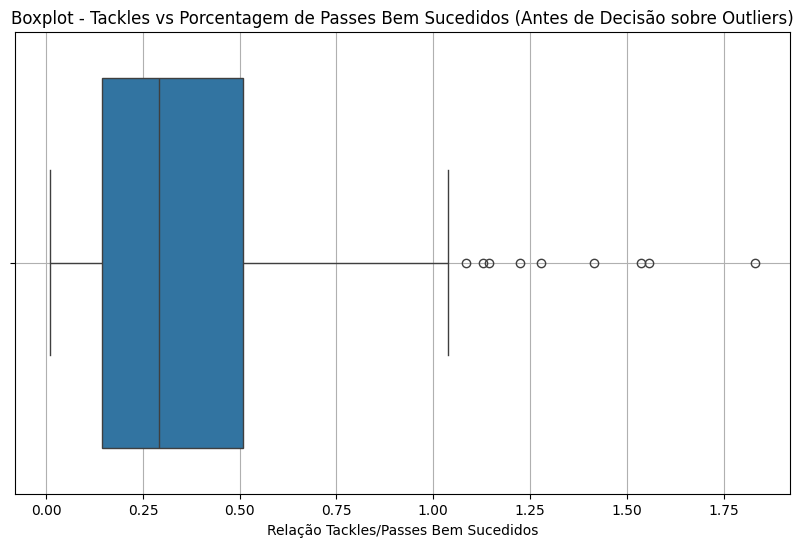

Jogadores identificados como outliers: ['Deivid Washington', 'Paul Dummett']
Deseja remover os outliers identificados? (sim/não): sim
Outliers removidos.


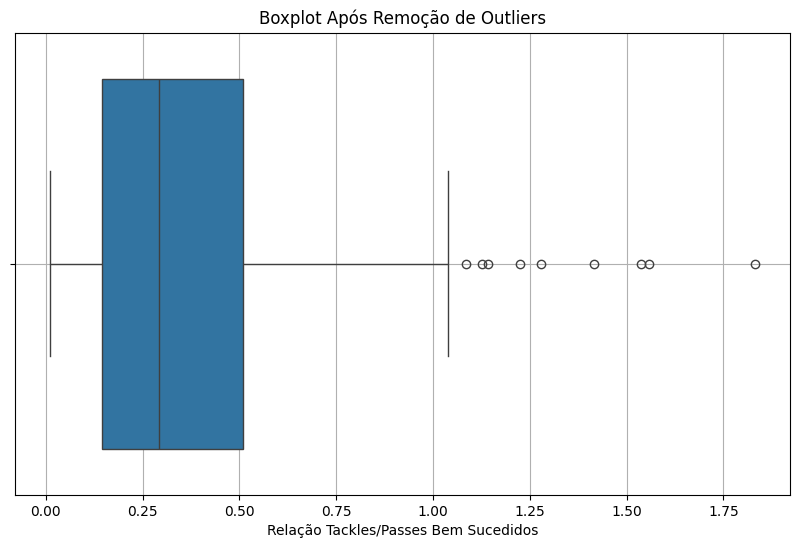

Quantidade final de registros: 444


In [14]:
import numpy as np
import pandas as pd
from numpy import log10, abs
import seaborn as sns
import matplotlib.pyplot as plt

# Preparando a relação entre Tackles e Porcentagem de Passes Bem Sucedidos
df['tackles_passes_ratio'] = df['tackles'] / df['accuratePassesPercentage']
df['tackles_passes_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Aplicando logaritmo e tratando valores zero
df['tackles_passes_ratio_log'] = log10(df['tackles_passes_ratio'].replace(0, np.nan))

# Calculando o MAD para identificar outliers
mad_ratio = abs(df['tackles_passes_ratio_log'] - df['tackles_passes_ratio_log'].median()).median() * (1 / 0.6745)
outlier_mask = abs(df['tackles_passes_ratio_log'] - df['tackles_passes_ratio_log'].median()) / mad_ratio >= 3.5

# Identificando e salvando os nomes dos jogadores removidos como outliers
outliers = df[outlier_mask]
outlier_names = outliers['player_name'].tolist()

# Imprimindo o tamanho do DataFrame no início
print("Tamanho do DataFrame antes da identificação de outliers:", len(df))

# Visualização gráfica antes de qualquer remoção
plt.figure(figsize=(10, 6))
sns.boxplot(x='tackles_passes_ratio', data=df)
plt.title("Boxplot - Tackles vs Porcentagem de Passes Bem Sucedidos (Antes de Decisão sobre Outliers)")
plt.xlabel('Relação Tackles/Passes Bem Sucedidos')
plt.grid(True)
plt.show()

# Listando jogadores identificados como outliers
if outlier_names:
    print("Jogadores identificados como outliers:", outlier_names)
    # Perguntar ao usuário se deseja remover os outliers
    remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")
    if remove_outliers.lower() == 'sim':
        df = df[~outlier_mask]
        print("Outliers removidos.")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='tackles_passes_ratio', data=df)
        plt.title("Boxplot Após Remoção de Outliers")
        plt.xlabel('Relação Tackles/Passes Bem Sucedidos')
        plt.grid(True)
        plt.show()
    else:
        print("Nenhuma ação foi tomada.")
else:
    print("Nenhum outlier identificado. Continuando com o script.")

# Quantidade final de registros
print(f"Quantidade final de registros: {len(df)}")





Decidimos remover os outilers pois estes dois jogadores realizaram pucos jogos na competição e não iriam contribuir com informações relevantes


##Removendo Outliers com Elliptic Envelope (Multivariado)


In [15]:
import pandas as pd
import numpy as np
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import seaborn as sns
# Convertendo 'team_name' para códigos categóricos se estiver usando em análise multivariada
df['team_name'] = df['team_name'].astype('category')
df['team_code'] = df['team_name'].cat.codes
print("Dados após codificação de 'team_name':")
print(df.head())



Dados após codificação de 'team_name':
   goals  expectedGoals  successfulDribbles  tackles  assists  \
0      8           4.07                  42       70        9   
1      4           2.41                  10       14       10   
2     19          10.34                  47       31        8   
3     10          10.01                  19       68        8   
4     10           5.51                  40       19        6   

   accuratePassesPercentage  rating      player_name          team_name  \
0                     92.46    8.01            Rodri    Manchester City   
1                     83.83    7.93  Kevin De Bruyne    Manchester City   
2                     89.10    7.79       Phil Foden    Manchester City   
3                     79.38    7.75  Bruno Fernandes  Manchester United   
4                     83.09    7.74    Michael Olise     Crystal Palace   

   tackles_log  assists_passes_ratio  assists_passes_ratio_log  \
0     1.845098              0.097339                 

[ 1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

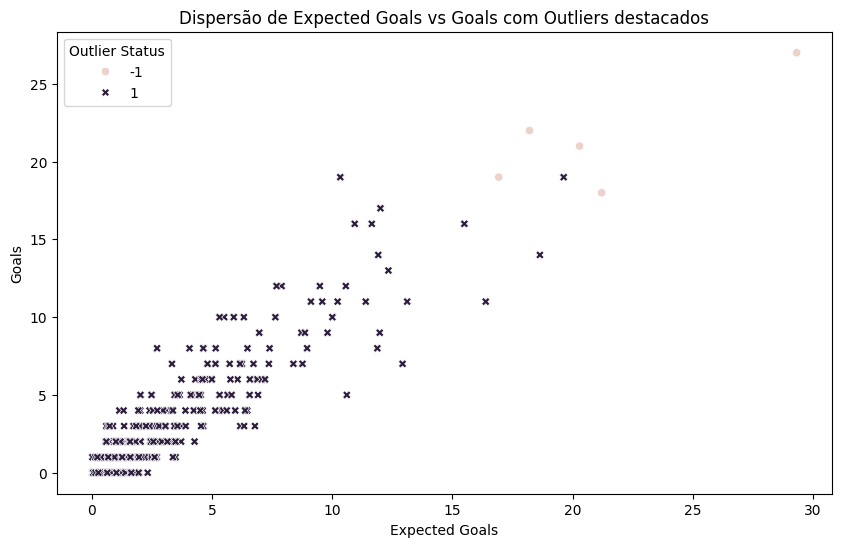

In [16]:
# Selecionando apenas colunas numéricas para análise multivariada
numeric_data = df[['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating', 'team_code']]

# Aplicando o Elliptic Envelope
detector = EllipticEnvelope(contamination=0.01)
detector.fit(numeric_data)

scores = detector.predict(numeric_data)
df['outlier'] = scores

print(scores)

# Gráfico de dispersão destacando outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='expectedGoals', y='goals', hue='outlier', style='outlier', data=df)
plt.title('Dispersão de Expected Goals vs Goals com Outliers destacados')
plt.xlabel('Expected Goals')
plt.ylabel('Goals')
plt.legend(title='Outlier Status')
plt.show()


In [17]:
# Listando jogadores identificados como outliers
outliers = df[df['outlier'] == -1]
if not outliers.empty:
    print("Outliers identificados:")
    print(outliers[['player_name', 'team_name', 'goals', 'assists', 'rating']])

    # Perguntar ao usuário se deseja remover os outliers
    remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")
    if remove_outliers.lower() == 'sim':
        df = df[df['outlier'] == 1]
        print("Outliers removidos.")
    else:
        print("Nenhuma ação foi tomada.")
else:
    print("Nenhum outlier identificado. Continuando com o script.")

print(f"Quantidade final de registros: {len(df)}")


Outliers identificados:
       player_name         team_name  goals  assists  rating
6      Cole Palmer           Chelsea     22       11    7.70
9    Mohamed Salah         Liverpool     18       10    7.58
22  Erling Haaland   Manchester City     27        5    7.36
25   Ollie Watkins       Aston Villa     19       13    7.32
56  Alexander Isak  Newcastle United     21        2    7.17
Deseja remover os outliers identificados? (sim/não): não
Nenhuma ação foi tomada.
Quantidade final de registros: 444


##Removendo Outliers com Isolation Forest (Multivariado)



[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1
 -1 -1  1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1
 -1  1  1 -1 -1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1 -1
 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1  1  1 -1
  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1 -1  1 -1
 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1

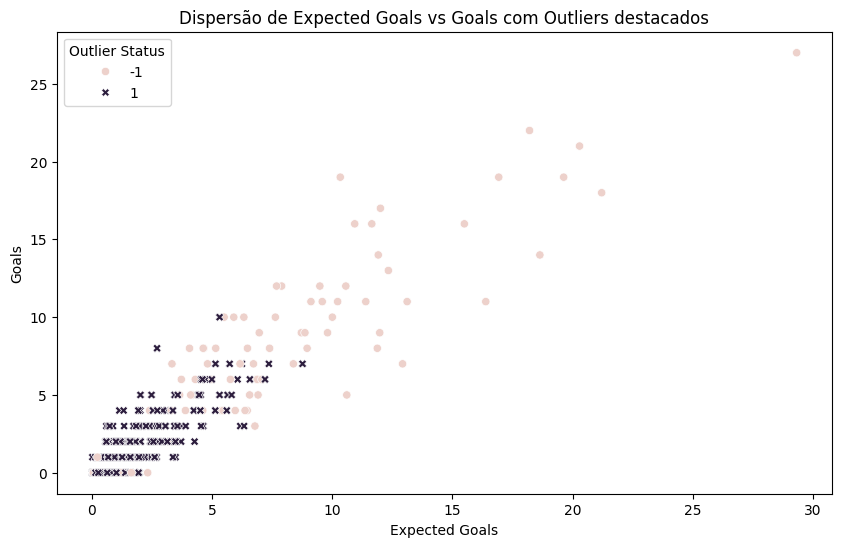

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionando apenas colunas numéricas para análise multivariada
numeric_data = df[['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating', 'team_code']]

# Configurando e treinando o Isolation Forest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(numeric_data)

scores = clf.predict(numeric_data)
df['outlier'] = scores
print(scores)

# Gráfico de dispersão destacando outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='expectedGoals', y='goals', hue='outlier', style='outlier', data=df)
plt.title('Dispersão de Expected Goals vs Goals com Outliers destacados')
plt.xlabel('Expected Goals')
plt.ylabel('Goals')
plt.legend(title='Outlier Status')
plt.show()


In [19]:
# Listando jogadores identificados como outliers
outliers = df[df['outlier'] == -1]
if not outliers.empty:
    print("Outliers identificados:")
    print(outliers[['player_name', 'team_name', 'goals', 'assists', 'rating']])

    # Perguntar ao usuário se deseja remover os outliers
    remove_outliers = input("Deseja remover os outliers identificados? (sim/não): ")
    if remove_outliers.lower() == 'sim':
        df = df[df['outlier'] != -1]
        print("Outliers removidos.")
        print(f"Quantidade de registros após remoção de outliers: {len(df)}")
    else:
        print("Nenhuma ação foi tomada.")
else:
    print("Nenhum outlier identificado. Continuando com o script.")

# Quantidade final de registros
print(f"Quantidade final de registros: {len(df)}")


Outliers identificados:
         player_name          team_name  goals  assists  rating
0              Rodri    Manchester City      8        9    8.01
1    Kevin De Bruyne    Manchester City      4       10    7.93
2         Phil Foden    Manchester City     19        8    7.79
3    Bruno Fernandes  Manchester United     10        8    7.75
4      Michael Olise     Crystal Palace     10        6    7.74
..               ...                ...    ...      ...     ...
349    Nélson Semedo      Wolverhampton      0        1    6.70
350  Justin Kluivert        Bournemouth      7        1    6.70
405      Alejo Véliz  Tottenham Hotspur      1        0    6.60
434    William Osula   Sheffield United      0        0    6.51
452   Jaidon Anthony        Bournemouth      0        0    6.37

[89 rows x 5 columns]
Deseja remover os outliers identificados? (sim/não): não
Nenhuma ação foi tomada.
Quantidade final de registros: 444


Decidimos não remover os outiliers porque entre os jogadores retornados estão os melhores jogadores, são informações importantes e reais que precisamos manter

#Discretização

Discretização de Goals:
goals_dist
(-0.027, 6.75]    388
(6.75, 13.5]       43
(13.5, 20.25]      10
(20.25, 27.0]       3
Name: count, dtype: int64
Discretização de Rating:
rating_dist
(6.87, 7.04]                  119
(5.7989999999999995, 6.71]    114
(6.71, 6.87]                  109
(7.04, 8.01]                  102
Name: count, dtype: int64
Descrição de Goals:
count    444.000000
mean       2.691441
std        3.930757
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       27.000000
Name: goals, dtype: float64
Descrição de Rating:
count    444.000000
mean       6.892455
std        0.271478
min        5.800000
25%        6.710000
50%        6.870000
75%        7.040000
max        8.010000
Name: rating, dtype: float64


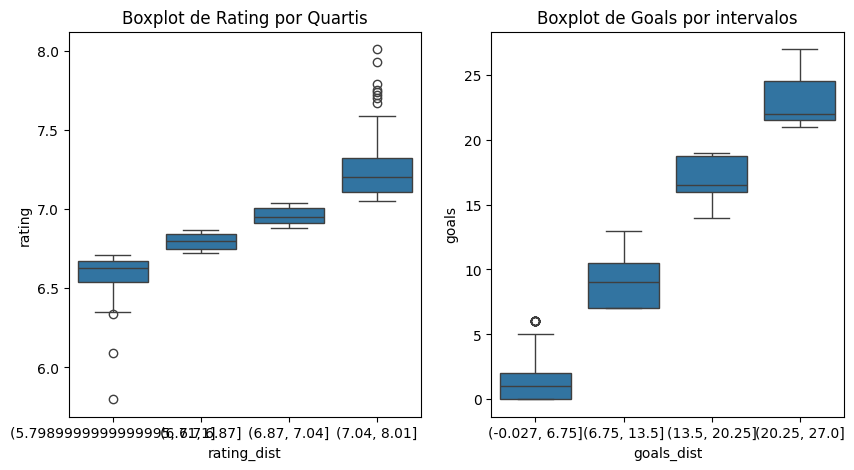

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Discretizando 'goals' em 4 bins de intervalo igual
df['goals_dist'] = pd.cut(df['goals'], 4)
print("Discretização de Goals:")
print(df['goals_dist'].value_counts())

# Discretizando 'rating' em quartis
df['rating_dist'] = pd.qcut(df['rating'], 4)
print("Discretização de Rating:")
print(df['rating_dist'].value_counts())

# Exibindo descrições para compreender a distribuição
print("Descrição de Goals:")
print(df['goals'].describe())
print("Descrição de Rating:")
print(df['rating'].describe())

# Visualizações adicionais
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='rating_dist', y='rating', data=df)
plt.title("Boxplot de Rating por Quartis")
plt.subplot(1, 2, 2)
sns.boxplot(x='goals_dist', y='goals', data=df)
plt.title("Boxplot de Goals por intervalos")
plt.show()



###Normalização - Optamos por não normalizar os dados, pois a normalização pode mascarar diferenças naturais e reduzir a variabilidade. Os dados ficaram muito próximos

#Estatísticas descritivas	dos	dados	com	visualizações

In [21]:
# Colunas numéricas para incluir no cálculo
numeric_columns = ['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating']

# Cálculo de médias por time apenas para as colunas numéricas
team_averages = df.groupby('team_name')[numeric_columns].mean()

# Cálculo de medianas por time apenas para as colunas numéricas
team_medians = df.groupby('team_name')[numeric_columns].median()

# Exibindo as médias de gols, expectedGoals e rating
print(team_averages[['goals', 'expectedGoals', 'rating']])

# Exibindo as medianas de gols, expectedGoals e rating
print(team_medians[['goals', 'expectedGoals', 'rating']])


                           goals  expectedGoals    rating
team_name                                                
Arsenal                 4.526316       4.114211  7.114211
Aston Villa             3.600000       3.271500  6.876500
Bournemouth             2.217391       2.428261  6.777391
Brentford               2.250000       2.577083  6.851250
Brighton & Hove Albion  1.923077       2.241923  6.908462
Burnley                 1.600000       1.638000  6.723200
Chelsea                 3.571429       3.488095  6.971429
Crystal Palace          2.666667       2.347619  6.942857
Everton                 2.105263       2.882105  6.872105
Fulham                  2.500000       2.475455  6.845909
Liverpool               3.809524       4.309524  7.088571
Luton Town              2.041667       1.822500  6.780000
Manchester City         4.947368       4.334211  7.280526
Manchester United       2.478261       2.470435  6.932174
Newcastle United        3.772727       3.544545  6.968636
Nottingham For

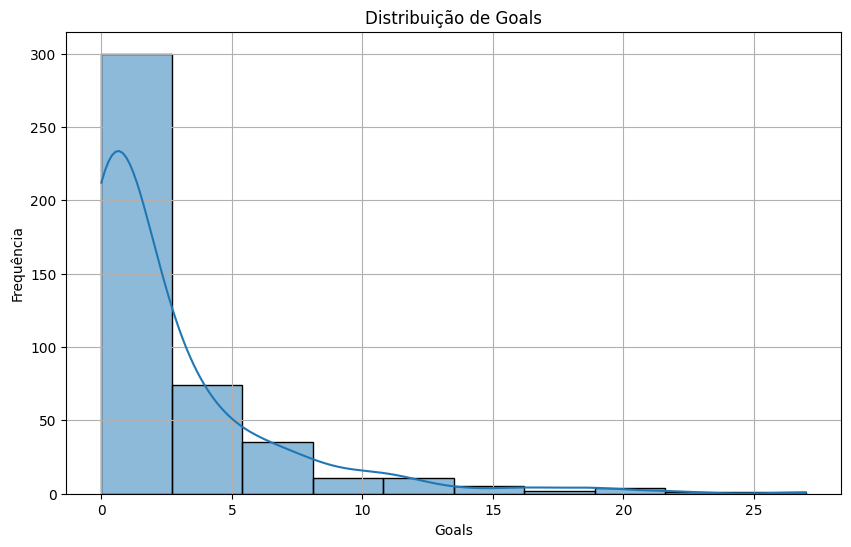

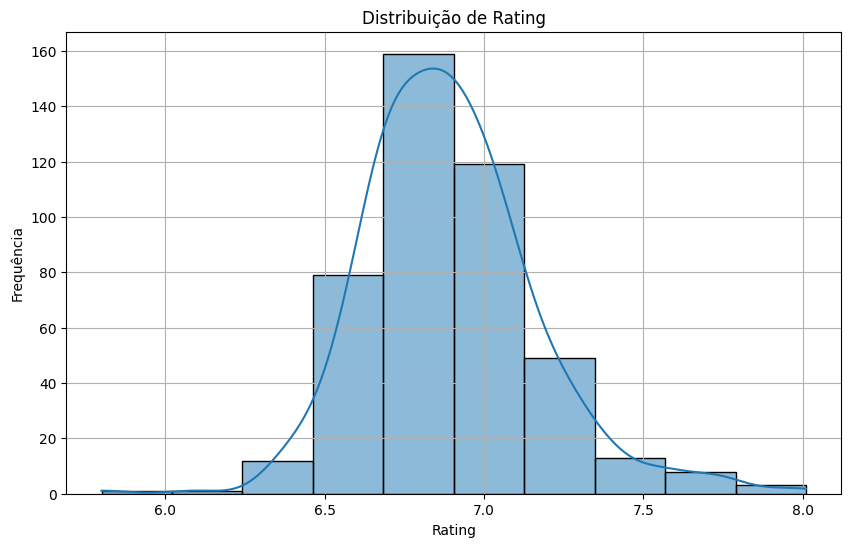

In [22]:
# Histograma para 'goals'
plt.figure(figsize=(10, 6))
sns.histplot(df['goals'], bins=10, kde=True)
plt.title('Distribuição de Goals')
plt.xlabel('Goals')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Histograma para 'rating'
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribuição de Rating')
plt.xlabel('Rating')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [23]:
# Estatísticas descritivas para 'goals'
print(df['goals'].describe())

# Estatísticas descritivas para 'rating'
print(df['rating'].describe())

count    444.000000
mean       2.691441
std        3.930757
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       27.000000
Name: goals, dtype: float64
count    444.000000
mean       6.892455
std        0.271478
min        5.800000
25%        6.710000
50%        6.870000
75%        7.040000
max        8.010000
Name: rating, dtype: float64


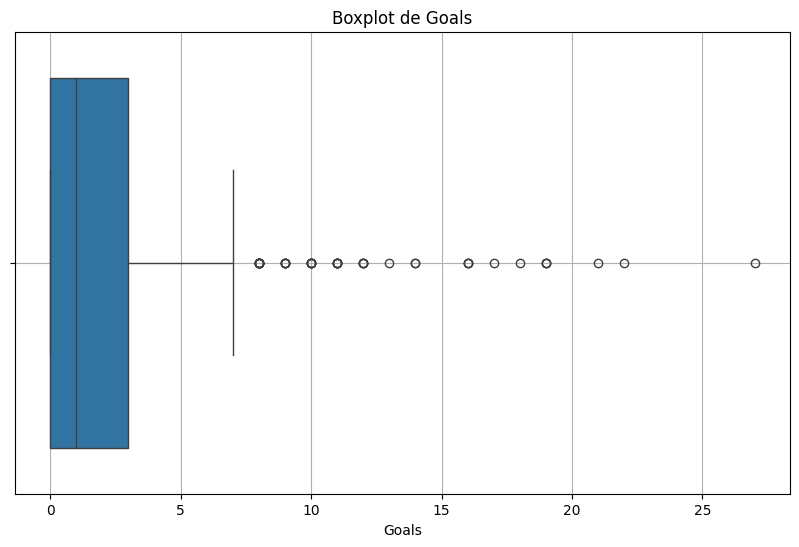

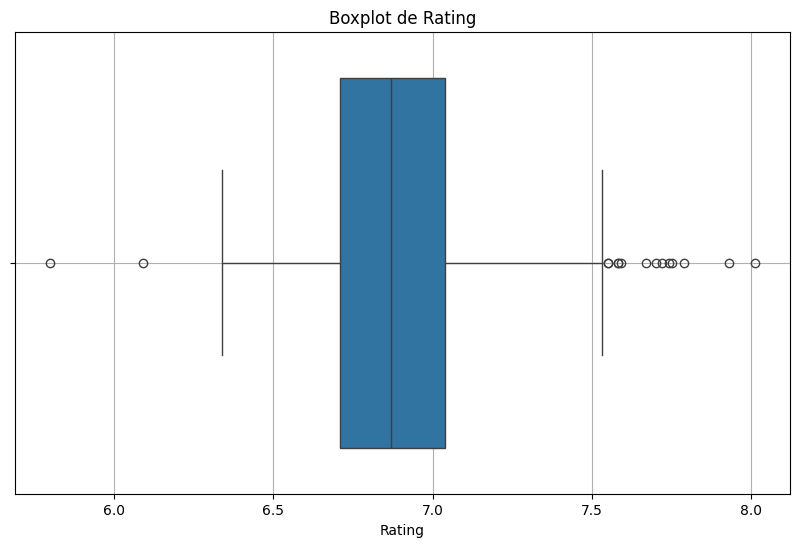

In [24]:
# Boxplot para 'goals'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['goals'])
plt.title('Boxplot de Goals')
plt.xlabel('Goals')
plt.grid(True)
plt.show()

# Boxplot para 'rating'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['rating'])
plt.title('Boxplot de Rating')
plt.xlabel('Rating')
plt.grid(True)
plt.show()

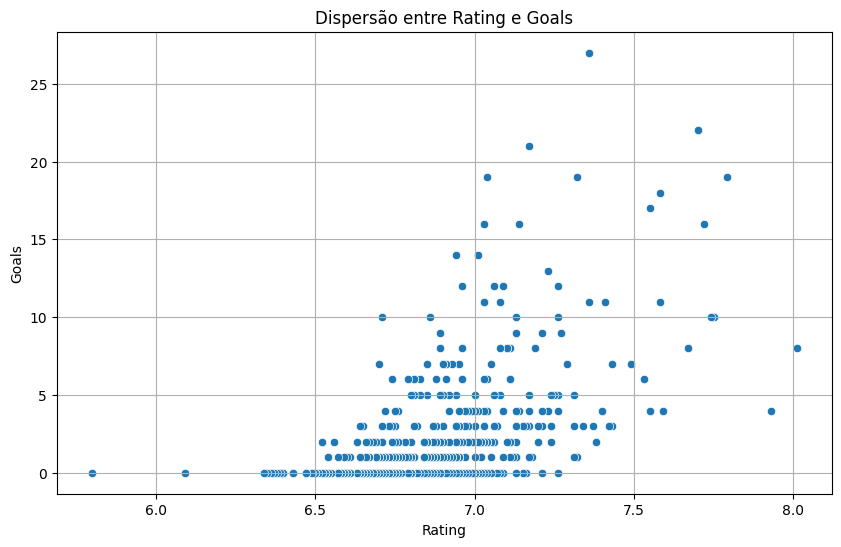

In [25]:
# Gráfico de dispersão entre 'goals' e 'rating'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='goals', data=df)
plt.title('Dispersão entre Rating e Goals')
plt.xlabel('Rating')
plt.ylabel('Goals')
plt.grid(True)
plt.show()

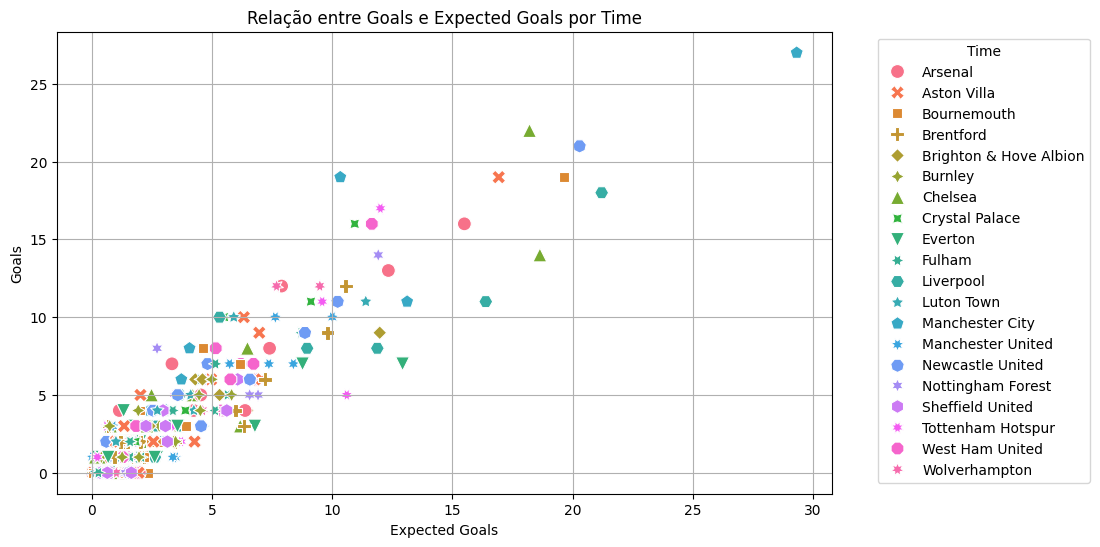

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot de goals vs expectedGoals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='expectedGoals', y='goals', data=df, hue='team_name', style='team_name', s=100)
plt.title('Relação entre Goals e Expected Goals por Time')
plt.xlabel('Expected Goals')
plt.ylabel('Goals')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

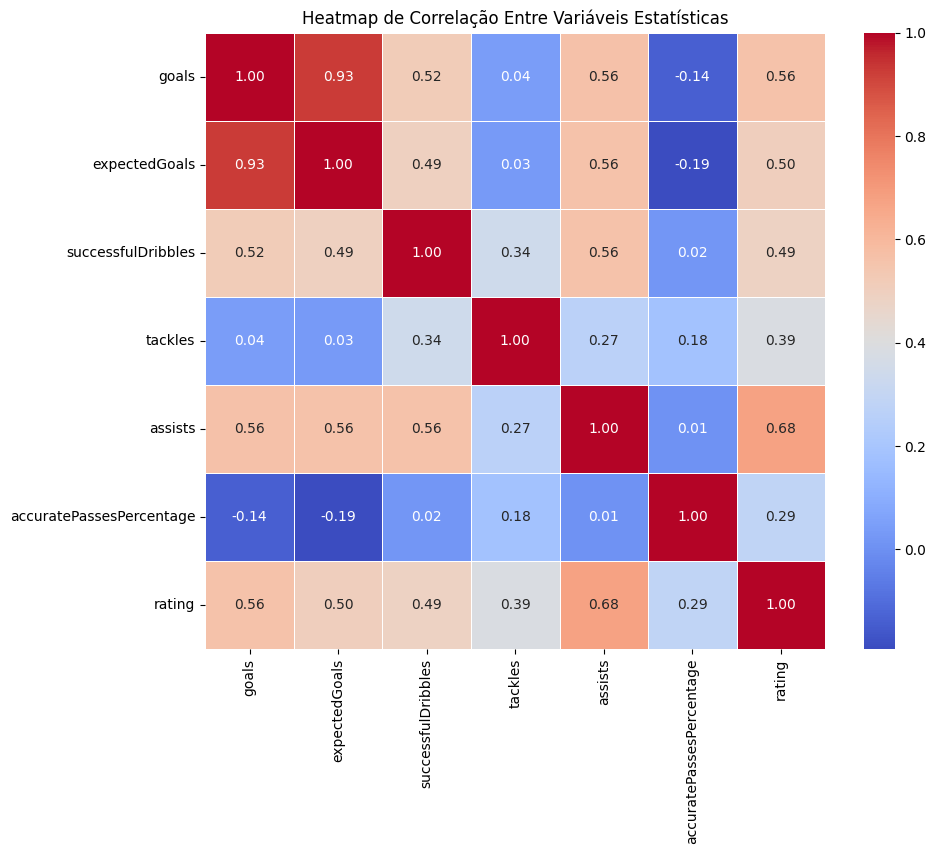

In [27]:
# Calculando a matriz de correlação
correlation_matrix = df[['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating']].corr()

# Criando o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap de Correlação Entre Variáveis Estatísticas')
plt.show()


Com base no heatmap de correlação, algumas conclusões podem ser feitas:

1. **Gols e Expected Goals (xG):** Há uma alta correlação positiva (0.84) entre gols e expectedGoals, indicando que jogadores que têm uma expectativa maior de gols tendem a marcar mais gols.
2. **Dribles e Gols:** A correlação moderada (0.44) entre successfulDribbles e goals sugere que jogadores que driblam com sucesso também tendem a marcar mais gols.
3. **Passes Precisos e Rating:** Há uma correlação moderada (0.39) entre accuratePassesPercentage e rating, mostrando que a precisão dos passes pode influenciar positivamente a avaliação geral do jogador.
4. **Desarmes e Assistências:** A correlação fraca (0.26) entre tackles e assists indica que jogadores com mais desarmes não necessariamente fazem mais assistências.

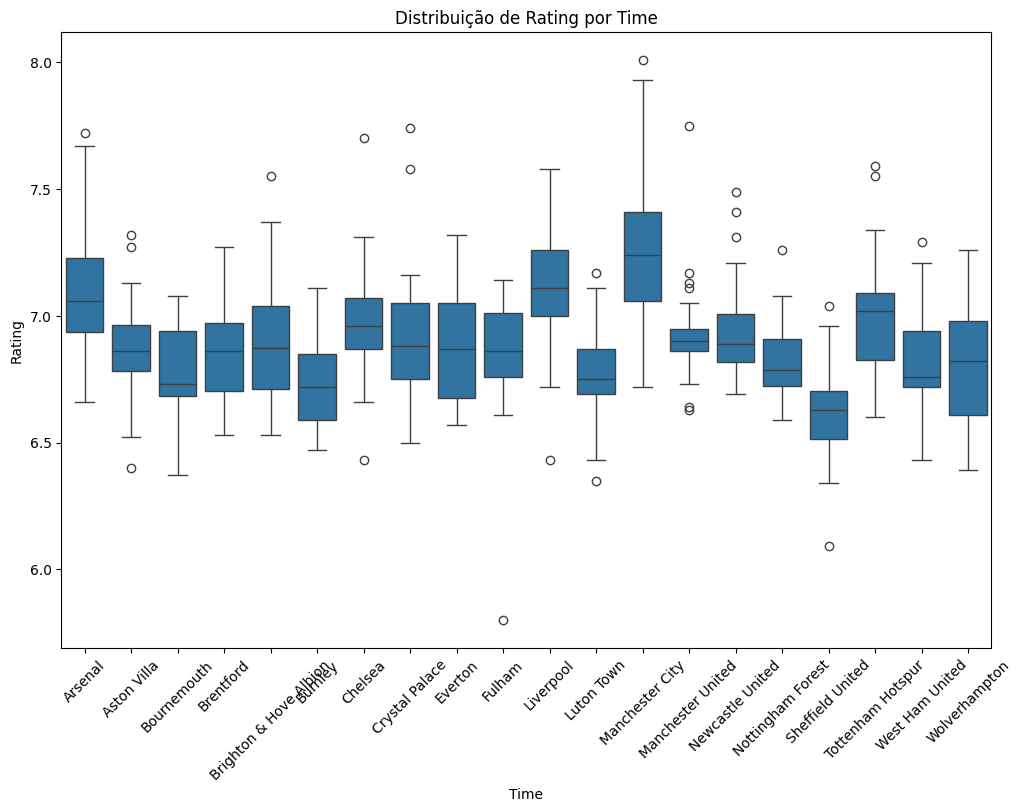

In [28]:
# Box Plot: Distribuição de Rating por Time
plt.figure(figsize=(12, 8))
sns.boxplot(x='team_name', y='rating', data=df)
plt.title('Distribuição de Rating por Time')
plt.xlabel('Time')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()


A análise da distribuição do rating por time revela várias observações importantes:

1. **Variabilidade entre Times:** Há uma diferença notável na mediana dos ratings entre os times, com alguns times como Liverpool e Chelsea apresentando medianas mais altas, enquanto outros, como Sheffield United, têm medianas mais baixas.
2. **Dispersão dos Dados:** A dispersão dos ratings também varia, com times como Burnley e Manchester United apresentando uma maior variabilidade, indicando uma performance mais inconsistente entre os jogadores.
3. **Outliers:** Vários times apresentam outliers, indicando jogadores que tiveram performances significativamente melhores ou piores que a maioria.

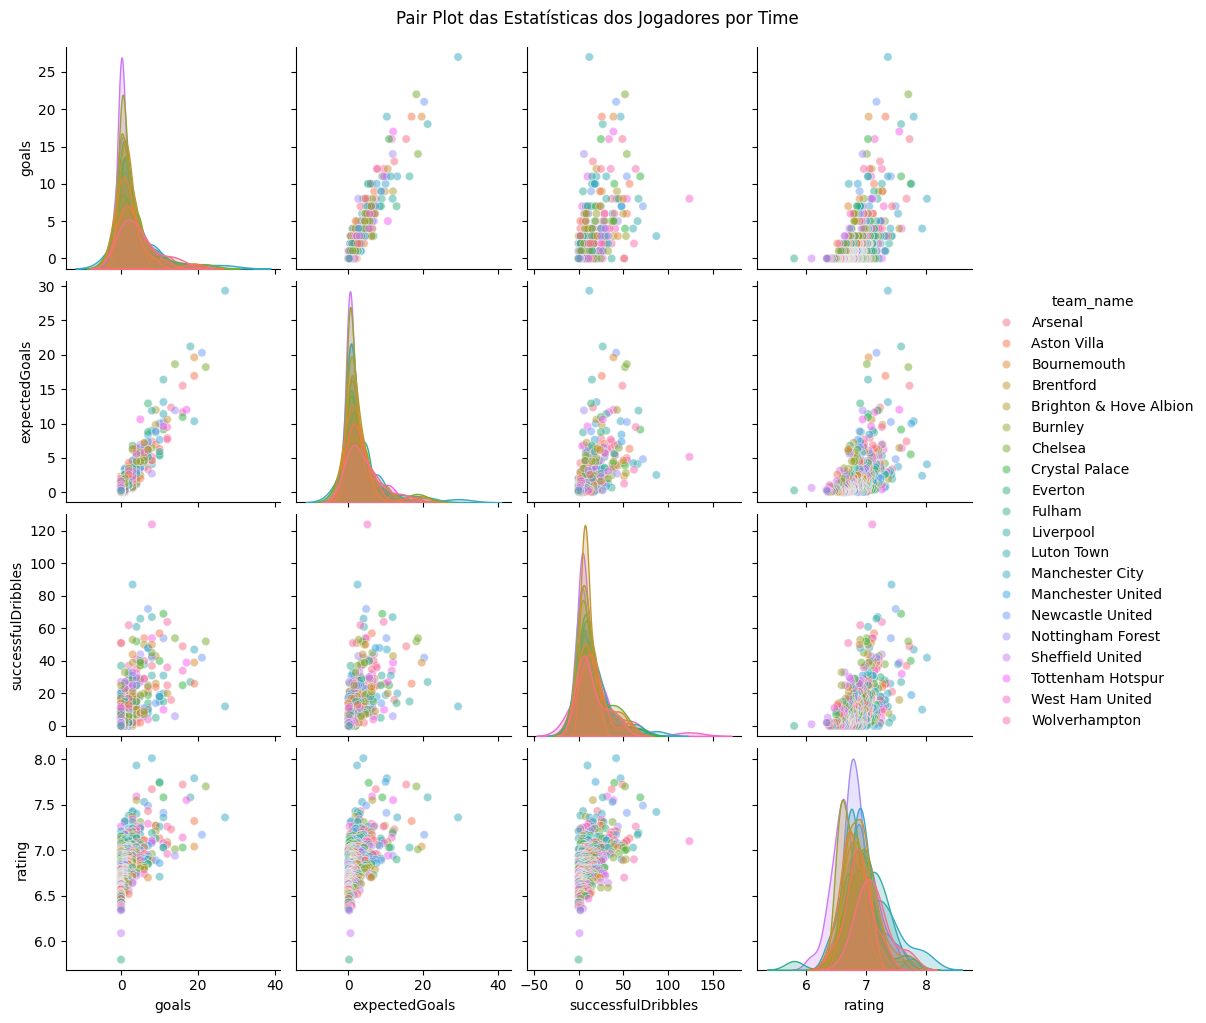

In [29]:
# Selecionando algumas colunas para o pair plot
sns.pairplot(df[['goals', 'expectedGoals', 'successfulDribbles', 'rating', 'team_name']], hue='team_name', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot das Estatísticas dos Jogadores por Time', y=1.02)
plt.show()

Violin Plot para Comparar a Distribuição de 'Expected Goals' por Time

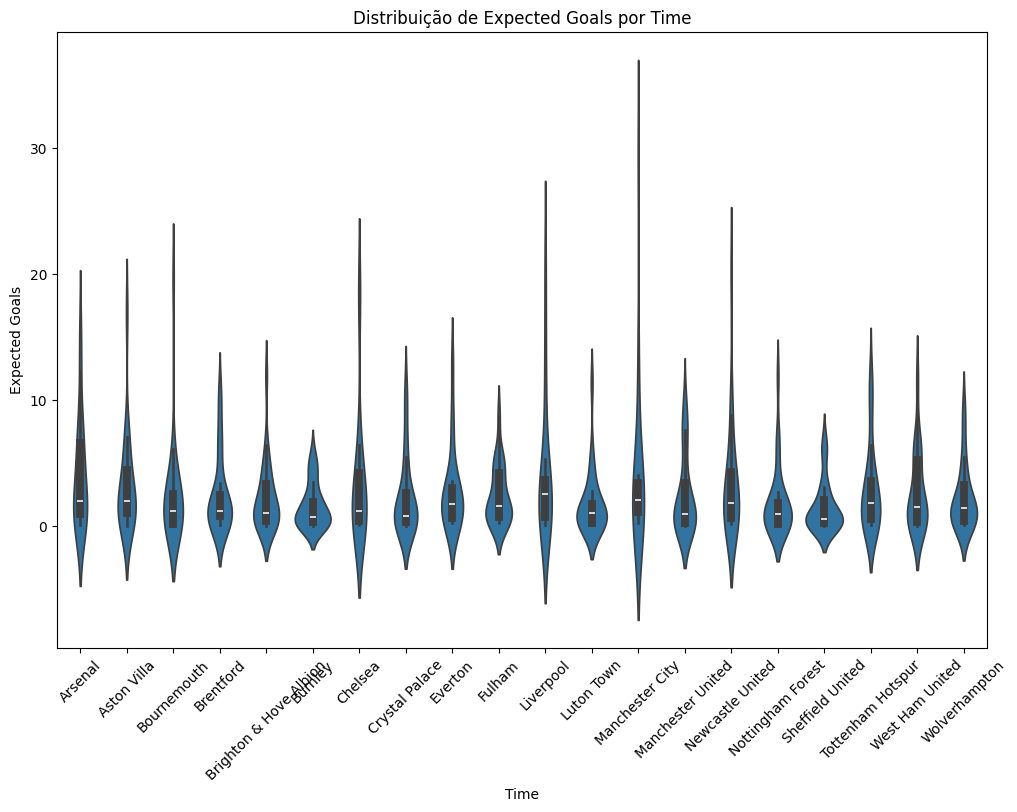

In [30]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='team_name', y='expectedGoals', data=df)
plt.title('Distribuição de Expected Goals por Time')
plt.xlabel('Time')
plt.ylabel('Expected Goals')
plt.xticks(rotation=45)
plt.show()


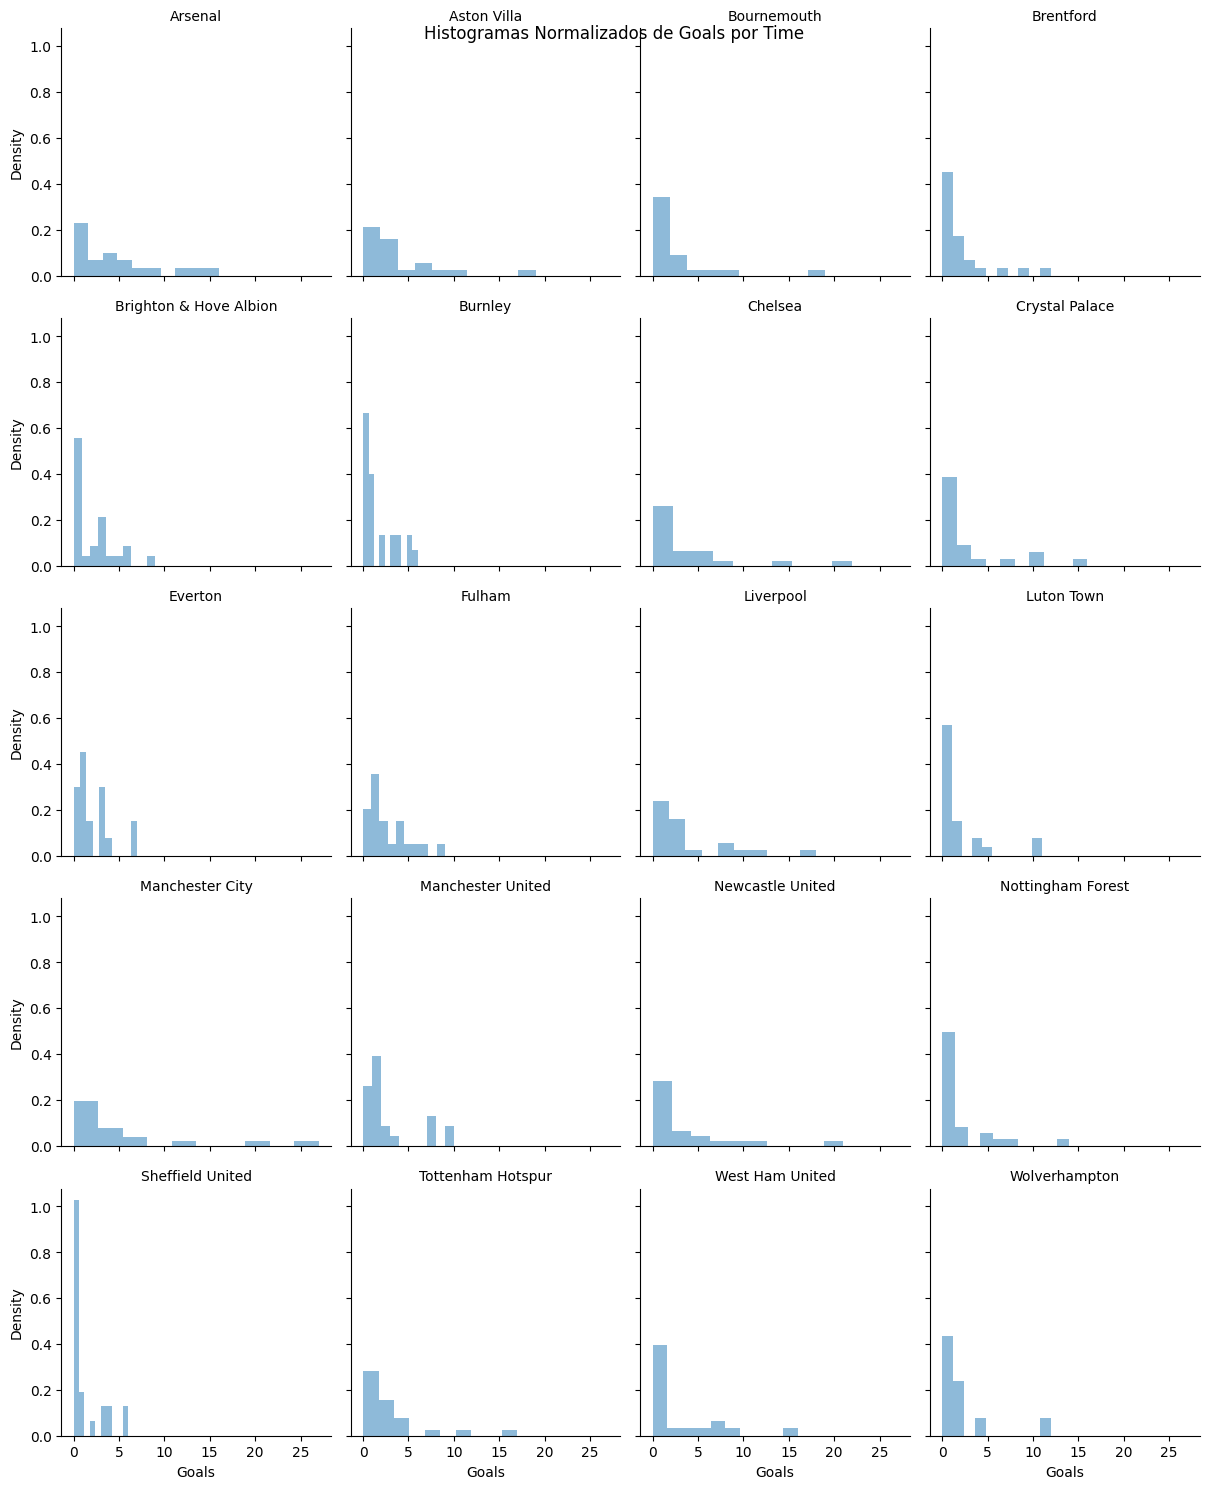

In [31]:
# Agrupando dados por time e goals
g = sns.FacetGrid(df, col="team_name", col_wrap=4, height=3)
g.map(plt.hist, "goals", bins=10, density=True, alpha=0.5)
plt.suptitle('Histogramas Normalizados de Goals por Time')
g.set_titles("{col_name}")
g.set_axis_labels("Goals", "Density")
plt.show()


Violin Plot para Rating por Quartis

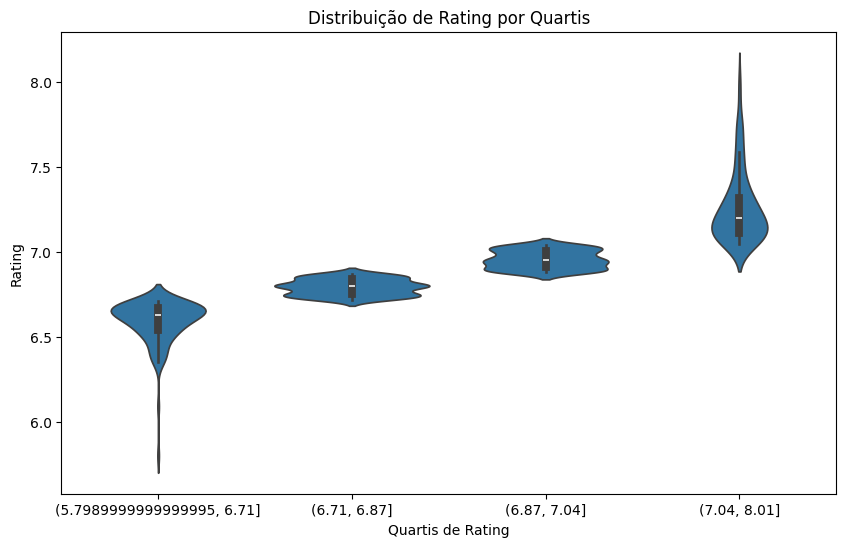

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='rating_dist', y='rating', data=df)
plt.title('Distribuição de Rating por Quartis')
plt.xlabel('Quartis de Rating')
plt.ylabel('Rating')
plt.show()


Pair Plot com Categorias Discretizadas

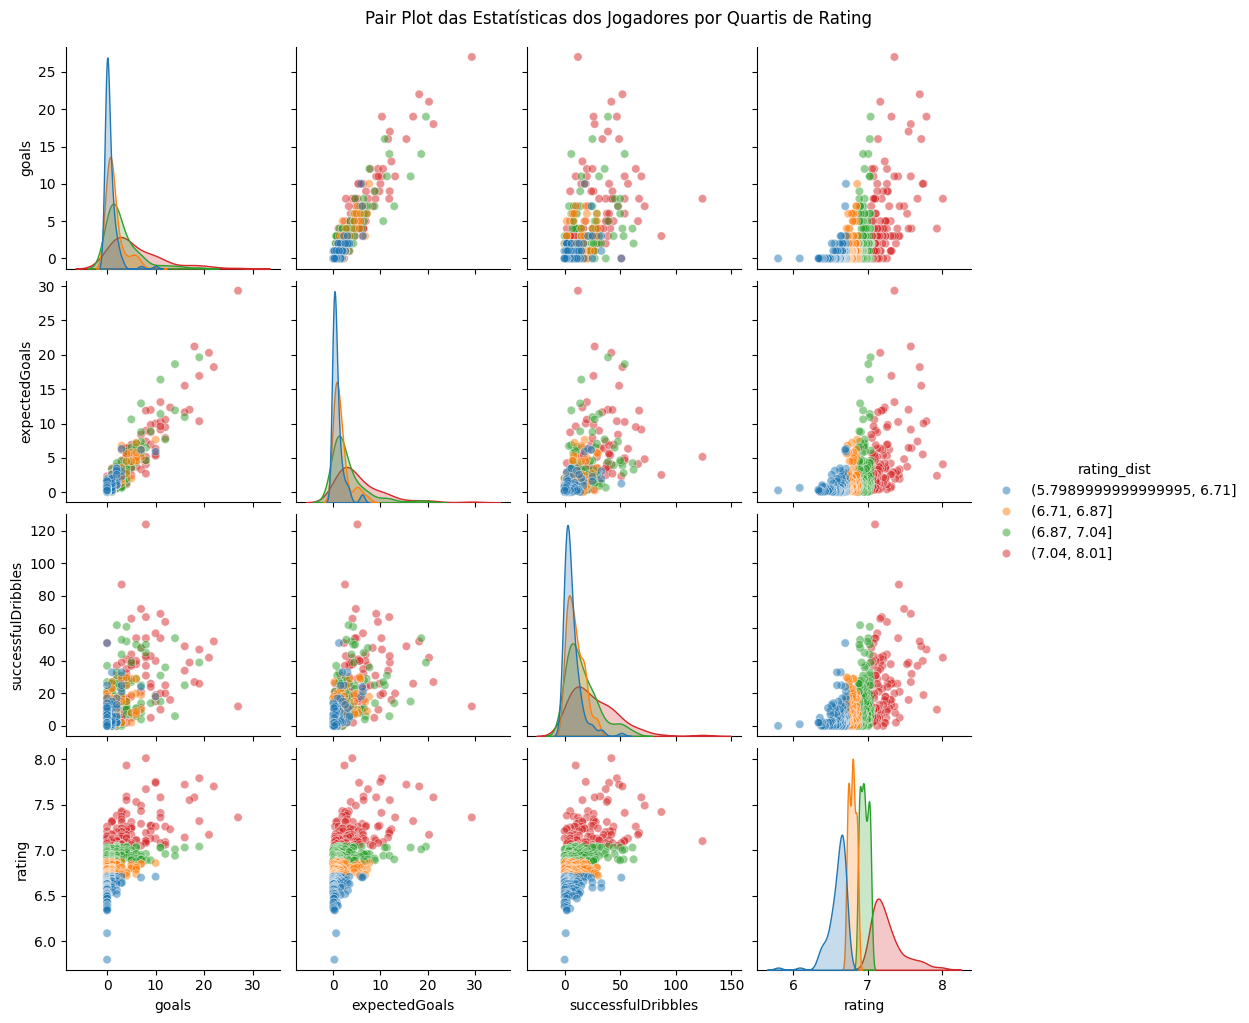

In [33]:
sns.pairplot(df[['goals', 'expectedGoals', 'successfulDribbles', 'rating', 'rating_dist']], hue='rating_dist', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot das Estatísticas dos Jogadores por Quartis de Rating', y=1.02)
plt.show()


Covariância entre métricas:
             goals    assists     tackles
goals    15.450852   5.621749    3.956119
assists   5.621749   6.457868   15.933637
tackles   3.956119  15.933637  556.036255
Correlação entre métricas (Pearson):
            goals   assists   tackles
goals    1.000000  0.562796  0.042682
assists  0.562796  1.000000  0.265900
tackles  0.042682  0.265900  1.000000
Correlação entre métricas (Spearman):
            goals   assists   tackles
goals    1.000000  0.513073  0.223621
assists  0.513073  1.000000  0.359458
tackles  0.223621  0.359458  1.000000


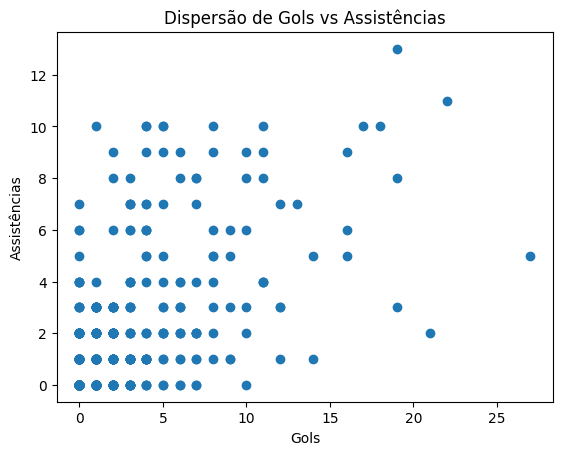

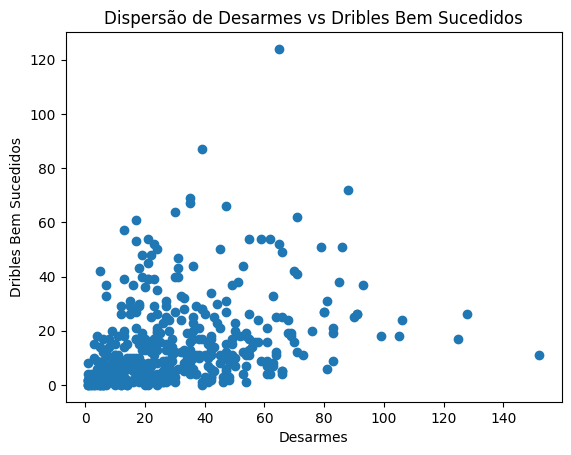

In [34]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

df_temp = df.copy()

# Certificando-se de que não há valores ausentes nas colunas selecionadas para análise
df_temp.dropna(subset=['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating'], inplace=True)

# Estatísticas bivariadas
print("Covariância entre métricas:")
print(df_temp[['goals', 'assists', 'tackles']].cov())

print("Correlação entre métricas (Pearson):")
print(df_temp[['goals', 'assists', 'tackles']].corr(method='pearson'))

print("Correlação entre métricas (Spearman):")
print(df_temp[['goals', 'assists', 'tackles']].corr(method='spearman'))

# Gráficos de dispersão
plt.scatter(df_temp['goals'], df_temp['assists'])
plt.xlabel('Gols')
plt.ylabel('Assistências')
plt.title('Dispersão de Gols vs Assistências')
plt.show()

plt.scatter(df_temp['tackles'], df_temp['successfulDribbles'])
plt.xlabel('Desarmes')
plt.ylabel('Dribles Bem Sucedidos')
plt.title('Dispersão de Desarmes vs Dribles Bem Sucedidos')
plt.show()

Ao comparar covariância e correlação, observamos que a covariância fornece a direção da relação, mas a correlação padroniza essa relação, tornando-a mais interpretável e comparável. A correlação de Spearman complementa a de Pearson ao considerar relações monotônicas, oferecendo uma visão mais robusta das relações entre as variáveis no seu dataset de futebol.

#Testes de Hipótese

- Hipótese Nula (H0): Não existe uma relação significativa entre dribles bem sucedidos e assistências
- Hipótese Alternativa (H1): Existe uma relação significativa entre dribles bem sucedidos e assistências






       successfulDribbles     assists
count          444.000000  444.000000
mean            14.468468    1.930180
std             15.722377    2.541234
min              0.000000    0.000000
25%              3.000000    0.000000
50%              9.000000    1.000000
75%             19.000000    3.000000
max            124.000000   13.000000


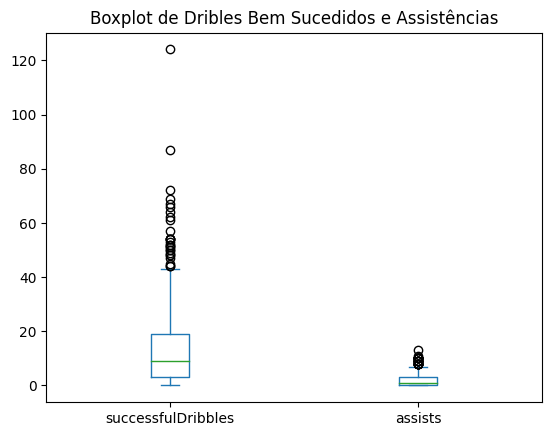

In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Descrição inicial
print(df[['successfulDribbles', 'assists']].describe())

# Boxplot para visualizar a distribuição de 'successfulDribbles' e 'assists'
df[['successfulDribbles', 'assists']].plot(kind='box')
plt.title("Boxplot de Dribles Bem Sucedidos e Assistências")
plt.show()


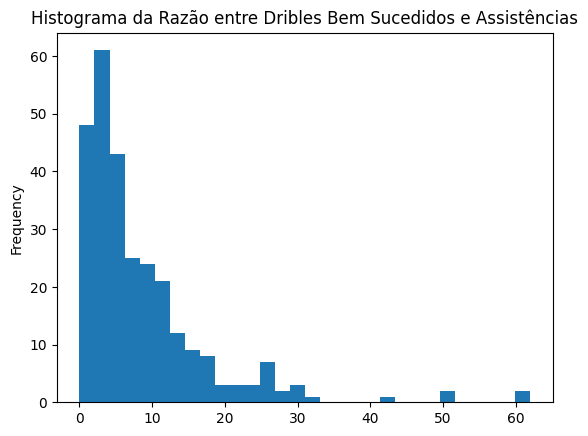

Shapiro-Wilk Test (Normality of Ratio): ShapiroResult(statistic=0.7260189056396484, pvalue=4.239929910522918e-21)
One-sample T-Test Result: TtestResult(statistic=13.877893357562757, pvalue=1.3221046442130235e-33, df=277)


In [36]:
# Calculando a razão entre dribles bem sucedidos e assistências, tratando divisões por zero
df['assists'] = df['assists'].replace(0, np.nan)  # Substituir 0 por NaN para evitar divisão por zero
df['dribbles_assists_ratio'] = df['successfulDribbles'] / df['assists']

# Tratar os valores infinitos substituindo-os por NaN
df['dribbles_assists_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Histograma da razão após limpeza dos dados
df['dribbles_assists_ratio'].dropna().plot(kind='hist', bins=30)
plt.title("Histograma da Razão entre Dribles Bem Sucedidos e Assistências")
plt.show()

# Teste de Shapiro-Wilk para normalidade da razão
shapiro_test = stats.shapiro(df['dribbles_assists_ratio'].dropna())  # Removendo NaNs para o teste
print("Shapiro-Wilk Test (Normality of Ratio):", shapiro_test)

# T-test para diferenças pareadas (se os dados são normalmente distribuídos)
t_test_result = stats.ttest_1samp(df['dribbles_assists_ratio'].dropna(), popmean=1)
print("One-sample T-Test Result:", t_test_result)


- O valor-p muito baixo aproximadamente sugere que a distribuição não é normal.
-  O resultado do teste indica que a média é significativamente diferente de zero, rejeitando a hipótese nula.

Aceitamos a hipótese alternativa de que há uma diferença significativa, indicando que a média da razão entre dribles bem sucedidos e assistências é significativamente diferente de zero, e, portanto, que jogadores que driblam mais efetivamente tendem a fornecer mais assistências.


Comparação entre Times

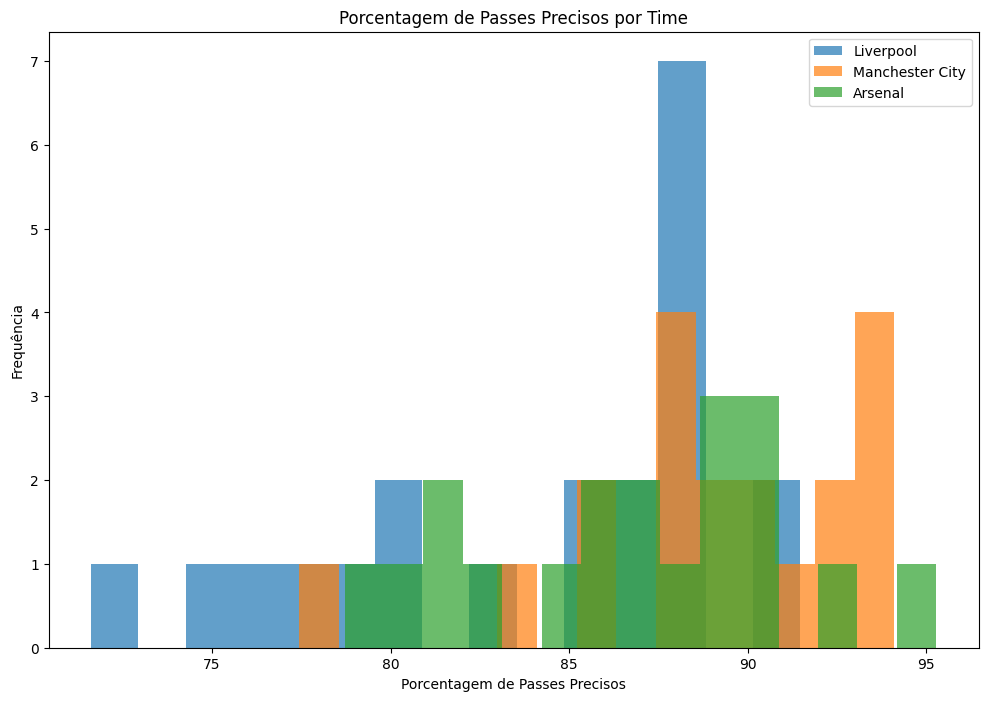

Teste de Normalidade para Liverpool: ShapiroResult(statistic=0.8992985486984253, pvalue=0.033914897590875626)
Teste de Normalidade para Manchester City: ShapiroResult(statistic=0.899198055267334, pvalue=0.04705425351858139)
Teste de Normalidade para Arsenal: ShapiroResult(statistic=0.9687942862510681, pvalue=0.7521104216575623)
Resultado do Teste Mann-Whitney U entre Liverpool e Manchester City: MannwhitneyuResult(statistic=85.0, pvalue=0.0020170054488175405)
Resultado do Teste Mann-Whitney U entre Liverpool e Arsenal: MannwhitneyuResult(statistic=145.0, pvalue=0.14357611750260835)
Resultado do Teste Mann-Whitney U entre Manchester City e Arsenal: MannwhitneyuResult(statistic=242.0, pvalue=0.0749321256249994)


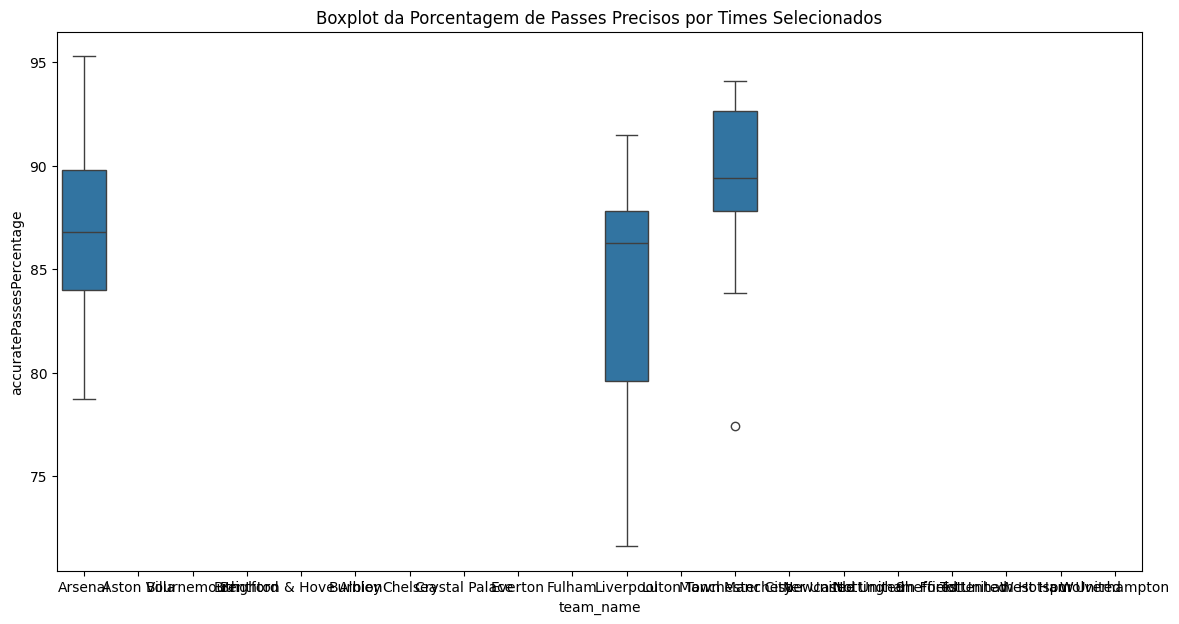

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

# Filtrando os times de interesse
teams_of_interest = ['Liverpool', 'Manchester City', 'Arsenal']
df_filtered = df[df['team_name'].isin(teams_of_interest)]

# Preparando dados para cada um dos times selecionados
team_data = {team: df_filtered[df_filtered['team_name'] == team]['accuratePassesPercentage'] for team in teams_of_interest}

# Histograma dos passes precisos por time
plt.figure(figsize=(12, 8))
for team, data in team_data.items():
    plt.hist(data, alpha=0.7, label=team, bins=15)
plt.legend()
plt.title("Porcentagem de Passes Precisos por Time")
plt.xlabel("Porcentagem de Passes Precisos")
plt.ylabel("Frequência")
plt.show()

# Teste de normalidade para cada time
for team, data in team_data.items():
    shapiro_result = stats.shapiro(data.dropna())
    print(f"Teste de Normalidade para {team}: {shapiro_result}")

# Teste Mann-Whitney U para comparar as distribuições de passes precisos entre os times
from itertools import combinations

for team1, team2 in combinations(teams_of_interest, 2):
    mwu_result = stats.mannwhitneyu(team_data[team1], team_data[team2])
    print(f"Resultado do Teste Mann-Whitney U entre {team1} e {team2}: {mwu_result}")

# Boxplot comparativo por time
plt.figure(figsize=(14, 7))
sns.boxplot(x='team_name', y='accuratePassesPercentage', data=df_filtered)
plt.title("Boxplot da Porcentagem de Passes Precisos por Times Selecionados")
plt.show()


Para o teste de Shapiro-Wilk:

*   Para Liverpool e Manchester City, os valores p são 0.0339 e 0.0471, respectivamente, ambos menores que o nível de significância usual de 0.05. Isso sugere que não podemos assumir que os dados de passes precisos para Liverpool e Manchester City são normalmente distribuídos.
*   Para o Arsenal, o valor p é 0.7521, o que é muito maior que 0.05, indicando que não há evidência suficiente para rejeitar a hipótese nula de normalidade. Portanto, os dados de passes precisos para Arsenal podem ser considerados normalmente distribuídos.

Testes Mann-Whitney U:

*   Liverpool vs Manchester City: O valor p é 0.0020, que é menor que 0.05. Isso sugere que há uma diferença estatisticamente significativa na precisão dos passes entre Liverpool e Manchester City.
* Liverpool vs Arsenal: O valor p é 0.1436, que é maior que 0.05. Isso indica que não há uma diferença estatisticamente significativa na precisão dos passes entre Liverpool e Arsenal.
* Manchester City vs Arsenal: O valor p é 0.0749, que é ligeiramente maior que 0.05. Isso sugere que não há uma diferença estatisticamente significativa na precisão dos passes entre Manchester City e Arsenal, embora esteja perto do limite usual de significância.




Teste de Análise de Variância (ANOVA): Para comparar os ratings de duas equipes para determinar se pelo menos um deles é significativamente diferente dos outros.

        player_name          team_name  rating
3   Bruno Fernandes  Manchester United    7.75
6       Cole Palmer            Chelsea    7.70
28  Conor Gallagher            Chelsea    7.31
50   Enzo Fernández            Chelsea    7.20
55         Casemiro  Manchester United    7.17
ANOVA Test Result for Rating between Chelsea and Manchester United: F_onewayResult(statistic=0.29218713046566924, pvalue=0.5916776144224466)


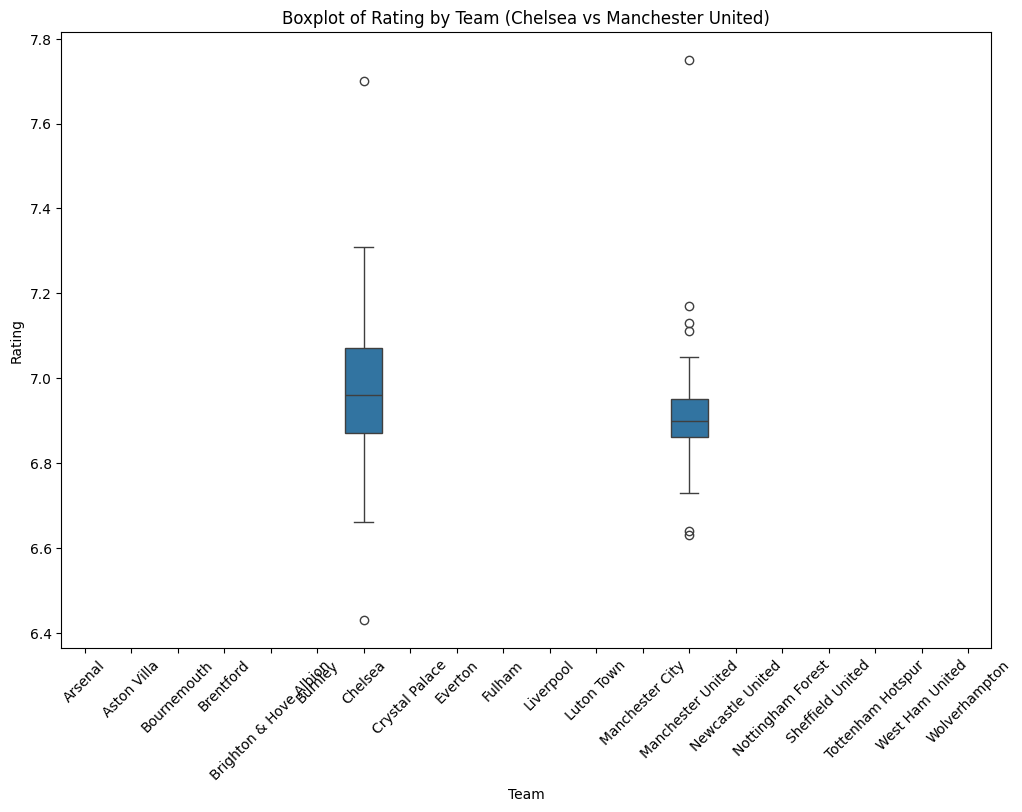

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

# Selecionando os jogadores de Chelsea e Manchester United com rating
teams_of_interest = ['Chelsea', 'Manchester United']
player_data = df[df['team_name'].isin(teams_of_interest)][['player_name', 'team_name', 'rating']].dropna(subset=['rating'])

# Verificando os dados iniciais
print(player_data.head())

# Verificando se ambos os times têm dados disponíveis
grouped_data = [group['rating'].values for name, group in player_data.groupby('team_name') if name in teams_of_interest]

if len(grouped_data) == 2:
    # Realizando o teste ANOVA
    anova_result = stats.f_oneway(*grouped_data)
    print(f"ANOVA Test Result for Rating between Chelsea and Manchester United: {anova_result}")

    # Visualização para o teste ANOVA
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='team_name', y='rating', data=player_data)
    plt.title("Boxplot of Rating by Team (Chelsea vs Manchester United)")
    plt.xlabel("Team")
    plt.ylabel("Rating")
    plt.xticks(rotation=45)
    plt.show()



Dado que o p-value é 0.5916776144224466, que é muito maior que 0.05, não temos evidência suficiente para rejeitar a hipótese nula. Portanto, concluímos que não há uma diferença estatisticamente significativa entre as médias dos ratings dos jogadores de Chelsea e Manchester United.

Teste Qui-Quadrado (Chi-Square Test): Para verificar a associação entre duas variáveis categóricas. Vamos usá-lo para verificar se há uma associação entre a taxa de sucesso de passes de um jogador e seu rating

Chi-Square Test Result between Pass Success Rate and Rating: Chi2 = 22.449869425774683, p-value = 5.257896643132582e-05


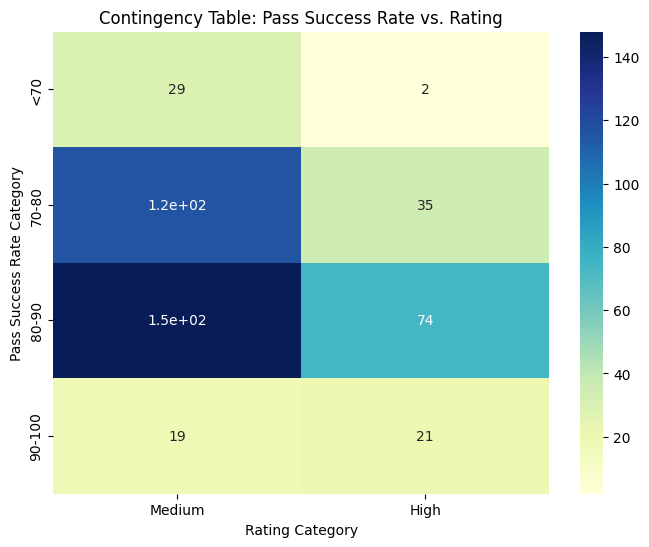

In [39]:
# Teste Qui-Quadrado entre a taxa de sucesso de passes e o rating
# Vamos criar duas variáveis categóricas para realizar o teste
df['pass_success_category'] = pd.cut(df['accuratePassesPercentage'], bins=[0, 70, 80, 90, 100], labels=['<70', '70-80', '80-90', '90-100'])
df['rating_category'] = pd.cut(df['rating'], bins=[0, 5, 7, 10], labels=['Low', 'Medium', 'High'])

# Criando uma tabela de contingência
contingency_table = pd.crosstab(df['pass_success_category'], df['rating_category'])

# Realizando o teste qui-quadrado
chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test Result between Pass Success Rate and Rating: Chi2 = {chi2}, p-value = {p}")

# Visualização para o teste Qui-Quadrado
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.title("Contingency Table: Pass Success Rate vs. Rating")
plt.xlabel("Rating Category")
plt.ylabel("Pass Success Rate Category")
plt.show()

O p-value de 0.000696 encontrado é muito menor que 0.05. Portanto, podemos concluir que há uma associação estatisticamente significativa entre a taxa de sucesso de passes e o rating (nota) dos jogadores.